# <center> Mecánica de los Fluidos computacional <center>

#  <center> Implementación de la solución para el  flujo <center>
#  <center>  en una cavidad 2D mediante el método SIMPLE con esquema Upwind <center>

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

$%operadores de latex simplificados
\newcommand{\parder}[2]{\frac{\partial #1}{\partial #2}}            % Derivada Parcial
\newcommand{\pardder}[2]{\frac{\partial^2 #1}{\partial #2^2}}       % Derivada Parcial Segunda
\newcommand{\parddercross}[3]{\frac{\partial^2 #1}{\partial #2 \partial #3}}  % Derivada Parcial Segunda cruzada
\newcommand{\pardern}[3]{\frac{\partial^{#3} #1}{\partial #2^{#3}}} % Derivada Parcial de orden #3
\newcommand{\totder}[2]{\frac{\text{d} #1}{\text{d} #2}}            % Derivada total
\newcommand{\totdder}[2]{\frac{\text{d}^2 #1}{\text{d} #2^2}}       % Derivada total Segunda
\newcommand{\totdern}[3]{\frac{\text{d}^{#3} #1}{\text{d} #2^{#3}}} % Derivada total de orden #3
\newcommand{\sustder}[2]{\frac{\text{D} #1}{\text{D} #2}}              % Derivada sustancial
\newcommand{\varg}{\phi}               % Variable genérica (escalar)
\newcommand{ \heat}{\dot{\mathcal{Q}}}
\newcommand{\half}{\frac{1}{2}}  
\newcommand{\xcoor}{x}                  % Coordenada x
\newcommand{\ycoor}{y}                  % Coordenada y
\newcommand{\varg}{\phi}               % Variable genérica (escalar)
\newcommand{\vol}{\mathcal{V}}   
\newcommand{\norm}{\hat{n}}
\newcommand{\ii}{\textbf{i}}
\newcommand{\abs}[1]{\left| #1 \right|}   
$

## Enunciado del problema


Implementar un algoritmo que resuelva las Ecs de Navier Stokes en una cavidad cuadrada de lado $l=2 \, m$ con una velocidad en la parte superior uniforme $U$ e independiente del tiempo. 

![consig_1](figs/cavity/cavitybc.png)

La pared inferior y las laterales tienen como condición la de no deslizamiento y la superficie superior puede considerarse como una pared que se desliza con una velocidad $U= cte$. Considerar un fluido y una velocidad $U$ tal que el Reynolds basado en la pared deslizante sea 400.


Se tiene como condición de contorno velocidades nulas en las paredes L (Left), R (Right), B (Bottom) y velocidad en y nula sobre la pared superior T(Top) $v_T=0$.  

## Ecuaciones de gobierno y estructura de datos

Las Ecs. de Navier Stokes junto con la conservación de la masa para un flujo incompresible, estacionario y bidimensional se expresan como

$$
\begin{align}
\frac{\partial (\rho u )}{\partial x} +\frac{\partial (\rho  v)}{\partial y} & =0\\
\frac{\partial (\rho u u)}{\partial x} +\frac{\partial (\rho u v)}{\partial y} & =\frac{\partial}{ \partial x}\left( \mu \frac{\partial u}{ \partial x}  \right) +\frac{\partial}{ \partial y}\left( \mu \frac{\partial u}{ \partial y}  \right)-\frac{\partial p}{\partial x}\\
\frac{\partial (\rho u v)}{\partial x} +\frac{\partial (\rho v v)}{\partial y} & =\frac{\partial}{ \partial x}\left( \mu \frac{\partial v}{ \partial x}  \right) +\frac{\partial}{ \partial y}\left( \mu \frac{\partial v}{ \partial y}  \right)-\frac{\partial p}{\partial y}
\end{align}
$$

En el contexto de los volúmenes finitos  dichas ecuaciones pueden expresarse de manera discreta como
$$  \begin{align}
\sum _{k=1}^{nc} ( \rho \vec{V}_k \cdot \hat n_k)u_{k}= \sum_{k=1}^{nc} \left(   \frac{ u_{k+1/2}-u_{k-1/2}}{\Delta x}\right)\mu_{k} A_{k} +  \frac{\partial p}{\partial x} \mathcal{V} \\
\sum _{k=1}^{nc} ( \rho \vec{V}_k \cdot \hat n_k)v_{j}= \left(   \frac{ v_{i+1/2}-v_{i-1/2}}{\Delta y}\right)\mu_{i-1} A_{i} -\left(   \frac{ v_{i-1/2}-v_{i-3  2}}{\Delta x}\right) \mu_{i-1} A_{i-1} +  \frac{\partial p}{\partial x} \mathcal{V}
\end{align}$$
donde k es el número de caras que encierran a la celda considerada. 


### Discretización del campo de presiones y velocidades

adoptando una malla staggered o alternada con celdas rectangulares de paso uniforme $\Delta x$ y $\Delta y$ para tres nodos de presión en x y y tres nodos de presión en y obtenemos
![estr_datos](figs/cavity/estr_datos_cavity.png)

De esta manera, en este caso tendremos 9 incógnitas de presión en 

Para evaluar el flujo difusivo en la interfaz izquierda se emplea una derivada descentrada, ya que la distancia a la condición de contorno es en este caso $\Delta x /2 $
$$\Gamma \frac{d\phi }{dx}_{1/2} =\Gamma_{1/2} \frac{\phi_1-\phi_0}{\Delta x/2} $$

Los flujos en la interfaz derecha resultan idénticos

Entonces, la Ecuación de conservación de $\phi $ para la primera celda resulta


$$  \begin{aligned} F_{3/2}   \frac{\phi_{1}+\phi_2}{2} -F_{0} \phi_{0} & = \left( D \right )_{3/2}  (\phi_{2} -\phi_1)- \left(   2 D\right)_{0} (\phi_1 -\phi_{0})   \\
\left( \frac{F_{3/2}}{2} +D_{3/2}+ 2 D_{0}  \right)  \phi_{1} +\left( -D_{3/2} +\frac{F_{3/2}}{2} \right )  \phi_{2}  & =    \left(   2 D_{0} +F_{0} \right) \phi_{0}   \end{aligned}
$$

$$S_f \hat{n}=S_f (\hat{e}\cdot \hat{n}) \hat e + S_f (\hat t \cdot \hat n) \hat t\\
\hat t =\hat n- \hat e
$$
 ### Condición de contorno derecha
 
 De la misma manera que para la condición izquierda, el flujo es conocido en la interfaz derecha. 
 
 ![title](figs/bc_der.png)
 Luego, puede escribirse la Ec. de conservación como
 
 $$  \begin{aligned} F_{n} \phi_{n}-  F_{n-3/2}   \frac{\phi_{n-1}+\phi_{n-2}}{2}  & =  \left(   2 D\right)_{n} (\phi_n -\phi_{n-1}) -\left( D \right )_{n-3/2}  (\phi_{n-1} -\phi_{n-2})   \\
\left( \frac{F_{n-3/2}}{2} +D_{n-3/2}+ 2 D_{n}  \right)  \phi_{n-1} +\left( -D_{n-3/2} -\frac{F_{n-3/2}}{2} \right )  \phi_{n-2}  & =    \left(   2 D_{n} -F_{n} \right) \phi_{n}   \end{aligned}
$$

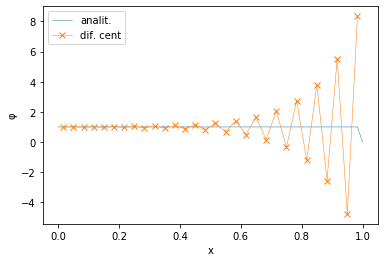

In [23]:
import numpy
from matplotlib import pyplot
%matplotlib inline

nx = 30 #numero de celdas en x
L  = 1.0 
ρ = 1.0

# condiciones de contorno
φ_0=1  ; φ_L=0;

dx = L / (nx)  #paso de discretizacion espacial

#discretización espacial
x = numpy.linspace(dx/2, L-dx/2, nx) # para el cálculo numérico
x_an=numpy.append([0], x) #discreti
x_an=numpy.append( x_an ,[L]) # para la evaluación de la sol. analítica

#inicialización
u = numpy.ones(nx+2)*0.5  # valor de la velocidad en cada celda
Γ = numpy.ones(nx+2)*0.001  # valor de la difusividad en cada celda

φ_an =numpy.empty(nx+2)

RHS =numpy.zeros(nx)

"""
Solución analítica

"""

#Pe_L=ρ *u*L/Γ 
def phi_an(x, u, Γ):
    phi_an =φ_0+(φ_L-φ_0)*(numpy.exp(ρ *u*x/Γ )-1) / (numpy.exp(ρ *u*L/Γ )-1)
    #print(phi_an)
    return phi_an

for i in range(1, nx+1):
    φ_an[i]=phi_an(x_an[i], u[i],Γ[i])
    

φ_an[0]=φ_0; φ_an[nx+1]=φ_L;

""" sol numérica

diferencias centradas
"""

#matriz de coefs de influencia
M_C=numpy.zeros((nx,nx))

#valores en el contorno
D_0=2*Γ[0]/dx;    D_L=2*Γ[nx+1]/dx; 
F_0=ρ*u[0];    F_L=ρ*u[nx+1];

# BC izquierda
u_3o2=(u[0]+u[1])/2  #u_3/2
Γ_3o2=(Γ[0]+Γ[1])/2 
D_3o2=Γ_3o2/dx
F_1o2=0;  F_3o2=ρ*u_3o2;

M_C[0][0] =F_3o2/2+D_3o2+D_0
M_C[0][1]   =-D_3o2+F_3o2/2


RHS[0] = (F_0+D_0)* φ_0
#ultima fila de la matriz
u_nm1o2=(u[nx-2]+u[nx-1])/2 #u_n-1/2
Γ_nm1o2=(Γ[nx-2]+Γ[nx-1])/2  ## Γ_n-1/2
D_nm1o2=Γ_nm1o2/dx
F_nm1o2=ρ*u_nm1o2;  

M_C[nx-1][nx-1] =-F_nm1o2/2+D_nm1o2+D_L
M_C[nx-1][nx-2]   =-D_nm1o2-F_nm1o2/2

RHS[nx-1] = (-F_L+D_L)* φ_L
for i in range(1, nx-1):
    #flujos convectivos
    u_im1o2=(u[i-1]+u[i])/2; u_ip1o2=(u[i]+u[i+1])/2 # u_i-1/2; u_i+1/2
    F_im1o2=ρ*u_im1o2;  F_ip1o2=ρ*u_ip1o2;
    #flujos difusivos
    Γ_im1o2=(Γ[i-1]+Γ[i])/2;  Γ_ip1o2=(Γ[i]+Γ[i+1])/2 
    D_im1o2=Γ_im1o2/dx;     D_ip1o2=Γ_ip1o2/dx;
    
    M_C[i][i-1] = -(D_im1o2+F_im1o2/2);
    M_C[i][i+1] = -(D_ip1o2-F_ip1o2/2);
    M_C[i][i]   =  D_im1o2+D_ip1o2+F_im1o2/2-F_ip1o2/2-(F_ip1o2-F_im1o2);

φ_cd=numpy.linalg.solve(M_C, RHS) #resuelvo el sist de ecs lineales 

pyplot.plot(x_an, φ_an,  lw=0.5)
pyplot.plot(x, φ_cd,  lw=0.5 , marker='x')
pyplot.xlabel("x")
pyplot.ylabel("φ")
pyplot.gca().legend(('analit.','dif. cent'))

## Diferencias "Upwind" (Aguas arriba)

Debido a que la discretización por diferencias centradas es unestable cuando el número de Pèclet es mayor a 2 fue necesario desarrollar otra estrategia de discretización para el término convectivo. Si la velocidad $u$  es positiva  en la interfaz, se adopta el valor de la variable transportada aguas arriba de la misma

$$\phi_{i+1/2} = \phi_i $$
$$\phi_{i-1/2} =  \phi_{i-1} $$

Si la velocidad es negativa y el flujo viene desde la derecha, entonces deben tomarse los valores de la derecha. Es decir, siempre se toman valores aguas arriba para la variable $\phi$


$$\phi_{i+1/2} = \phi_{i+1} $$
$$\phi_{i-1/2} =  \phi_{i} $$

Reemplazando dichos valores en la Ec. discretizada se obtiene

$$   \begin{align}  F_{i+1/2}   \phi_i  -F_{i-1/2}  \phi_{i-1}   &= \left(  D \right )_{i+1/2}  (\phi_{i+1} -\phi_i)- \left( D \right)_{i-1/2} (\phi_i -\phi_{i-1}) &\text{si }u>0 \\
F_{i+1/2}   \phi_{i+1}  -F_{i-1/2}  \phi_{i}   &= \left(  D \right )_{i+1/2}  (\phi_{i+1} -\phi_i)- \left( D \right)_{i-1/2} (\phi_i -\phi_{i-1}) &\text{si }u<0 
\end{align} $$

El sistema de ecuaciones para las celdas dentro del dominio se reduce a 
$$ \begin{align}  \left( F_{i+1/2} + D_{i+1/2} +D_{i-1/2} \right)  \phi_i + \left(  -D_{i+1/2} \right) \phi_{i+1}    + \left( - F_{i-1/2} - D_{i-1/2} \right)\phi_{i-1}  & =0  &\text{si }u>0  \\ 
\left( -F_{i-1/2} + D_{i+1/2} +D_{i-1/2} \right)  \phi_i + \left(  -D_{i+1/2}+  F_{i+1/2} \right) \phi_{i+1}    + \left( - D_{i-1/2} \right)\phi_{i-1}  & =0  &\text{si }u<0 \end{align} $$

Resulta conveniente desarrollar una expresión única, que sea independiente del valor de la velocidad. Teniendo en cuenta además que 

$$ \begin{align}
F_{i+1/2}<0\quad & \,\text{y} &F_{i-1/2}<0 \quad \text{si }\quad& u<0 \\
F_{i+1/2}>0\quad & \,\text{y} &F_{i-1/2}>0 \quad  \text{si }\quad& u>0
\end{align}
$$

pueden reescribirse las ecuaciones del sistema como
$$   \left( \text{max}(F_{i+1/2}, 0)- \text{min}(F_{i-1/2}, 0)  + D_{i+1/2} +D_{i-1/2} \right)  \phi_i + \left(  \text{min}(F_{i+1/2, 0})-D_{i+1/2} \right) \phi_{i+1}    + \left( - \text{max}(F_{i-1/2}, 0) - D_{i-1/2} \right)\phi_{i-1}   =0   $$


### Condición de contorno izquierda 

Resta determinar las ecuaciones que gobiernan el comportamiento en los contornos
![title](figs/bc_izq.png)

Los flujos difusivos se calculan de la misma manera que para el esquema centrado, ya que la difusión es isotrópica. 
La diferencia está en los flujos convectivos: deben tomarse flujos aguas arriba. 
Si la velocidad es positiva, la Ecuación de conservación de $\phi $ para la primera celda resulta


$$  \begin{aligned} F_{3/2}   \phi_{1} -F_{0} \phi_{0} & = \left( D \right )_{3/2}  (\phi_{2} -\phi_1)- \left(   2 D\right)_{0} (\phi_1 -\phi_{0})   \\
\left( F_{3/2} +D_{3/2}+ 2 D_{0}  \right)  \phi_{1} +\left( -D_{3/2}  \right )  \phi_{2}  & =    \left(   2 D_{0} +F_{0} \right) \phi_{0}   \end{aligned}
$$

Si la velocidad es negativa, entonces $\phi_1$ es transportado hacia afuera del dominio y no viaja "información" del contorno izquierdo hacia el dominio por efecto de convección

![title](figs/bc_izq_u<0.png)

$$  \begin{aligned} F_{3/2}   \phi_{2} -F_{0} \phi_{1} & = \left( D \right )_{3/2}  (\phi_{2} -\phi_1)- \left(   2 D\right)_{0} (\phi_1 -\phi_{0})   \\
\left(  D_{3/2}+ 2 D_{0} -F_{0} \right)  \phi_{1} +\left( F_{3/2}-D_{3/2}  \right )  \phi_{2}  & =    \left(   2 D_{0}  \right) \phi_{0}   \end{aligned}
$$

Se puede unificar la Ec. en el contorno izquierdo para cualquier valor de u como
$$ \left(  D_{3/2}+ 2 D_{0} -\text{min}(F_{0},0) + \text{max} (F_{3/2}, 0) \right)  \phi_{1} +\left( \text{min} (F_{3/2}, 0)-D_{3/2}  \right)  \phi_{2}   =    \left(   2 D_{0}   +\text{max}(F_{0},0) \right)  \phi_{0}$$

 ### Condición de contorno derecha
 
 De la misma manera que para la condición izquierda, debe hacerse la diferencia si la velocidad es positiva o negativa. 
 
 ![title](figs/bc_der.png)
 Si la velocidad u es positiva,   no llega información al dominio desde el contorno derecho. Puede escribirse la Ec. de conservación como
 
 $$  \begin{aligned} 
 F_{n} \phi_{n-1}-  F_{n-3/2}   \phi_{n-2}  & =  \left(   2 D \right)_{n} (\phi_n -\phi_{n-1}) -\left( D \right)_{n-3/2}  (\phi_{n-1} -\phi_{n-2})   \\
\left( F_{n} +D_{n-3/2}+ 2 D_{n}  \right)  \phi_{n-1} +\left( -D_{n-3/2}-  F_{n-3/2}  \right )  \phi_{n-2}  & =    \left(   2 D_{n}  \right) \phi_{n}   \end{aligned} $$

En caso de que $u<0$, la información provienen desde la derecha.
![title](figs/bc_der_u<0.png)
 
 $$  \begin{aligned}
 F_{n} \phi_{n}-  F_{n-3/2}   \phi_{n-1}  & =  \left(   2 D \right)_{n} (\phi_n -\phi_{n-1}) -\left( D \right)_{n-3/2}  (\phi_{n-1} -\phi_{n-2})   \\
\left( -F_{n-3/2} +D_{n-3/2}+ 2 D_{n}  \right)  \phi_{n-1} +\left( -D_{n-3/2} \right)  \phi_{n-2}  & =    \left(   2 D_{n} -F_{n} \right) \phi_{n}   \end{aligned}
$$

Unificando las ecs. se obtiene

$$
\left( \text{max}(F_{n}, 0)-\text{min}(F_{n-3/2}, 0) +D_{n-3/2}+ 2 D_{n}  \right)  \phi_{n-1} +\left( -D_{n-3/2}-  \text{max}(F_{n-3/2}, 0)  \right )  \phi_{n-2}   =    \left(   2 D_{n} -\text{max}(F_{n}, 0) \right) \phi_{n}   $$


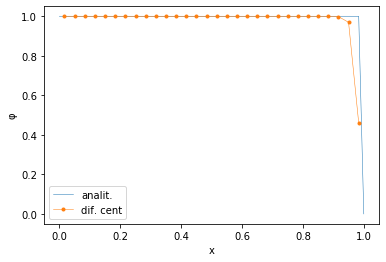

In [24]:
"""
Esquema de diferencias hacia atrás (upwind)
para el método de los volúmenes finitos
"""
#matriz de coefs de influencia
M_U=numpy.zeros((nx,nx))

#valores en el contorno
D_0=2*Γ[0]/dx;    D_L=2*Γ[nx+1]/dx; 
F_0=ρ*u[0];    F_L=ρ*u[nx+1];

# BC izquierda
u_3o2=(u[0]+u[1])/2  #u_3/2
Γ_3o2=(Γ[0]+Γ[1])/2 
D_3o2=Γ_3o2/dx
F_1o2=0;  F_3o2=ρ*u_3o2;

M_U[0][0] =-min(F_0, 0)+max(F_3o2,0)+D_3o2+D_0 #CIR Courant Isaacs Rees
M_U[0][1]   =-D_3o2- min(F_3o2,0)


RHS[0] = (max(0,F_0)+D_0)* φ_0
#ultima fila de la matriz
u_nm3o2=(u[nx-2]+u[nx-1])/2 #u_n-1/2
Γ_nm3o2=(Γ[nx-2]+Γ[nx-1])/2  ## Γ_n-1/2
D_nm3o2=Γ_nm3o2/dx
F_nm3o2=ρ*u_nm3o2;  

M_U[nx-1][nx-1] =max(F_L, 0)-min(F_nm3o2, 0)+D_nm1o2+D_L
M_U[nx-1][nx-2]   =-D_nm1o2-F_nm1o2/2

RHS[nx-1] = (-max(F_L, 0)+D_L)* φ_L
for i in range(1, nx-1):
    #flujos convectivos
    u_im1o2=(u[i-1]+u[i])/2; u_ip1o2=(u[i]+u[i+1])/2 # u_i-1/2; u_i+1/2
    F_im1o2=ρ*u_im1o2;  F_ip1o2=ρ*u_ip1o2;
    #flujos difusivos
    Γ_im1o2=(Γ[i-1]+Γ[i])/2;  Γ_ip1o2=(Γ[i]+Γ[i+1])/2 
    D_im1o2=Γ_im1o2/dx;     D_ip1o2=Γ_ip1o2/dx;
    
    M_U[i][i-1] = (-D_im1o2-max(F_im1o2, 0));
    M_U[i][i+1] = (-D_ip1o2+min(F_ip1o2, 0));
    M_U[i][i]   =  D_im1o2+D_ip1o2+max(F_im1o2, 0)-min(F_ip1o2, 0)-(F_ip1o2-F_im1o2);

φ_ud=numpy.linalg.solve(M_U, RHS)

pyplot.plot(x_an, φ_an,  lw=0.5)
#pyplot.plot(x, φ_cd,  lw=0.5 , marker='x')
pyplot.plot(x, φ_ud,  lw=0.5 , marker='.')                    
pyplot.xlabel("x")
pyplot.ylabel("φ")
pyplot.gca().legend(('analit.','dif. cent','dif. upwind'))

## Convección difusión inestacionaria

En caso de que se tenga un término inestacionario en la Ec. de convección difusión, se plantea la Ec. de conservación inestacionaria. La misma expresa que la variación temporal de $\phi$ en la celda es igual al balance de los flujos convectivos y difusivos


 
$$  \frac{(\rho \phi_i)^{n+1}-(\rho \phi_i)^{n}}{\Delta t}  \Delta x= F_{i-1/2}   \phi_{i-1/2} -F_{i+1/2} \phi_{i+1/2}  + \left( D \right )_{i+1/2}  (\phi_{i+1} -\phi_i)- \left( D \right)_{i-1/2} (\phi_i -\phi_{i-1})   $$

Para determinar el valor de  $\phi_i$ en el instante $t_{n+1}$ debe evaluarse el balance de los flujos del miembro derecho. Esto puede hacerse de dos maneras:

- Evaluando los flujos en el instante $t_{n}$.  En este caso puede despejarse el valor de $ \phi_i^{n+1}$ en función de los $\phi_j$, obteniéndose un esquema explícito


$$  \rho \phi_i^{n+1}=\rho \phi_i^{n}+ \left( F_{i-1/2}^n   \phi_{i-1/2}^n -F_{i+1/2}^n \phi_{i+1/2}^n \right)\frac{\Delta t}  {\Delta x}  + \left[ D_{i+1/2}^n  (\phi_{i+1}^n -\phi_i^n)-  D _{i-1/2}^n (\phi_i^n -\phi_{i-1}^n)\right] \frac{\Delta t}  {\Delta x}    $$

- Evaluando los flujos en el instante $t_{n+1}$.  En este caso se obtiene un sistema de ecuaciones cuyas incógnitas son  $ \phi_i^{n+1}$, $ \phi_{i+1}^{n+1}$ y $ \phi_{i-1}^{n+1}$. Se obtiene  un esquema implícito.

$$  \rho \phi_i^{n+1}-\left( F_{i-1/2}^{n+1}   \phi_{i-1/2}^{n+1} -F_{i+1/2}^{n+1} \phi_{i+1/2}^{n+1} \right)\frac{\Delta t}  {\Delta x}   -\left[ D_{i+1/2}^{n+1}  (\phi_{i+1}^{n+1} -\phi_i^{n+1})-  D _{i-1/2}^{n+1} (\phi_i^{n+1} -\phi_{i-1}^{n+1})\right] \frac{\Delta t}  {\Delta x}=\rho \phi_i^{n}    $$

- Evaluando los flujos en  alún intstante de tiempo intermedio entre $t_{n+1}$ y $t_{n}$, o bien en algún instante sucesivo, como $t_{n+2}$.  Dependiendo de la elección del instante, se obtienen esquemas tipo Crank Nicolson o métodos multipaso. En todos los casos  son esquemas implícitos.


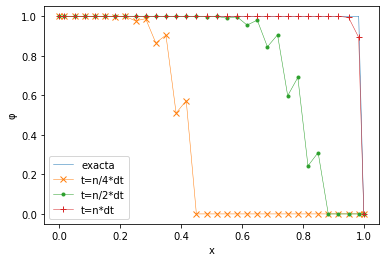

In [25]:
"""
Esquema explícito para la ecuación de conveccion difusion inestacionaria
Discretización espacial con esquema upwind
"""
#discretización temporal
nt = 50 # numero de pasos de tiempo
CFL=.9; Fo=0.25;
umax=numpy.amax(u[:]); Γmax=numpy.amax(Γ);

dt=min(CFL*dx/umax,Fo*dx**2/Γmax) #paso de tiempo
#dt=0.1
# array para guardar los resultados  en cada paso de tiempo
φ_sol=numpy.zeros((nx+2, nt))

#condición inicial
φ_i=numpy.zeros((nx+1))

#condición inicial no uniforme
#φ_i = numpy.ones(nx)      #numpy function ones()
#φ_i[int(.5 / dx):int(1 / dx + 1)] = 2

#valores en el contorno
D_0=2*Γ[0]/dx;   D_L=2*Γ[nx+1]/dx; 
F_0=ρ*u[0];    F_L=ρ*u[nx+1];

# BC izquierda

φ_sol[0, :]=φ_0;


u_3o2=(u[0]+u[1])/2  #u_3/2
Γ_3o2=(Γ[0]+Γ[1])/2 
D_3o2=Γ_3o2/dx
F_1o2=0;  F_3o2=ρ*u_3o2;

# BC derecha
φ_sol[nx+1, :]=φ_L;


u_nm3o2=(u[nx-2]+u[nx-1])/2 #u_n-1/2
Γ_nm3o2=(Γ[nx-2]+Γ[nx-1])/2  ## Γ_n-1/2
D_nm3o2=Γ_nm3o2/dx
F_nm3o2=ρ*u_nm3o2;  



RHS[nx-1] = (-max(F_L, 0)+D_L)* φ_L
for j in range (nt):
    #contorno izq 
    φ_sol[1, j]= φ_sol[1, j-1]+(F_0*φ_sol[0, j-1]-F_3o2* φ_sol[1, j-1])*dt/ρ/dx +(D_3o2*(φ_sol[2, j-1]-φ_sol[1, j-1])-D_0*(φ_sol[1, j-1]-φ_sol[0, j-1])) *dt/ρ/dx 

        
    for i in range(2, nx): #interior del dominio
        #flujos convectivos
        u_im1o2=(u[i-1]+u[i])/2; u_ip1o2=(u[i]+u[i+1])/2 # u_i-1/2; u_i+1/2
        F_im1o2=ρ*u_im1o2;  F_ip1o2=ρ*u_ip1o2;
        #flujos difusivos
        Γ_im1o2=(Γ[i-1]+Γ[i])/2;  Γ_ip1o2=(Γ[i]+Γ[i+1])/2 
        D_im1o2=Γ_im1o2/dx;     D_ip1o2=Γ_ip1o2/dx;
        
        φ_sol[i, j]= φ_sol[i, j-1]+(F_im1o2*φ_sol[i-1, j-1]-F_ip1o2* φ_sol[i, j-1])*dt/ρ/dx +(D_ip1o2*(φ_sol[i+1, j-1]-φ_sol[i, j-1])-D_im1o2*(φ_sol[i, j-1]-φ_sol[i-1, j-1]))*dt/ρ/dx 
    #contorno derecho
    φ_sol[nx, j]= φ_sol[nx, j-1]+(F_nm3o2*φ_sol[nx-1, j-1]-F_L* φ_sol[nx, j-1])*dt/ρ/dx +(D_L*(φ_sol[nx+1, j-1]-φ_sol[nx, j-1])-D_nm3o2*(φ_sol[nx, j-1]-φ_sol[nx-1, j-1]))*dt/ρ/dx 
#soluciones para distintos instantes

pyplot.plot(x_an, φ_an,  lw=0.5)
pyplot.plot(x_an, φ_sol[: , int(nt/4)],  lw=0.5 , marker='x')
pyplot.plot(x_an, φ_sol[: , int(nt/2)],  lw=0.5 , marker='.')                    
pyplot.plot(x_an, φ_sol[: , nt-1],  lw=0.5 , marker='+')
pyplot.xlabel("x")
pyplot.ylabel("φ")
pyplot.gca().legend(('exacta','t=n/4*dt','t=n/2*dt','t=n*dt'))

## Solución implícita de la Ec. de convección difusión inestacionaria

Retomando la expresión implícita de la Ley de conservación de la Ec. de convección difusion

$$  \rho \phi_i^{n+1}-\left( F_{i-1/2}^{n+1}   \phi_{i-1/2}^{n+1} -F_{i+1/2}^{n+1} \phi_{i+1/2}^{n+1} \right)\frac{\Delta t}  {\Delta x}   -\left[ D_{i+1/2}^{n+1}  (\phi_{i+1}^{n+1} -\phi_i^{n+1})-  D _{i-1/2}^{n+1} (\phi_i^{n+1} -\phi_{i-1}^{n+1})\right] \frac{\Delta t}  {\Delta x}=\rho \phi_i^{n}    $$

proponiendo un esquema tipo upwind para la discretización del flujo convectivo y reordenando los términos 


$$  \rho \phi_i^{n+1}-\left( F_{i-1/2}^{n+1}   \phi_{i-1}^{n+1} -F_{i+1/2}^{n+1} \phi_{i}^{n+1} \right)\frac{\Delta t}  {\Delta x}   -\left[ D_{i+1/2}^{n+1}  (\phi_{i+1}^{n+1} -\phi_i^{n+1})-  D _{i-1/2}^{n+1} (\phi_i^{n+1} -\phi_{i-1}^{n+1})\right] \frac{\Delta t}  {\Delta x}=\rho \phi_i^{n}    $$
Simplificando la expresión con sympy se obtiene el sistema de Ecuaciones para una celda genérica i


                                                                              
-D_{i+1/2}⋅(φⁿ⁺¹ᵢ₊₁ - φⁿ⁺¹ᵢ) + D_{i-1/2}⋅(-φⁿ⁺¹ᵢ₋₁ + φⁿ⁺¹ᵢ) + F_{i+1/2}⋅φⁿ⁺¹ᵢ 
                                                                              

                      Δₓ⋅ρ⋅(-φⁿᵢ + φⁿ⁺¹ᵢ)
- F_{i-1/2}⋅φⁿ⁺¹ᵢ₋₁ + ───────────────────
                               Δₜ        


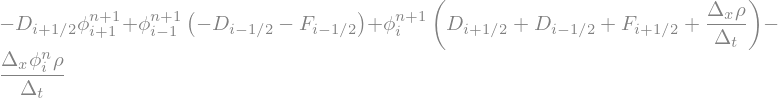

In [34]:
import sympy
from sympy import init_printing
init_printing(use_latex=True)

phi_i_n,phi_i_np1, phi_im1_np1, phi_ip1_np1 = sympy.symbols('phi_i^n phi_i^n+1 phi^n+1_i-1 phi^n+1_i+1')
F_ip1o2,F_im1o2, D_ip1o2, D_im1o2 = sympy.symbols('F_{i+1/2} F_{i-1/2}  D_{i+1/2} D_{i-1/2}')

rhos,  dxs = sympy.symbols(' rho  Delta_x')

dts= sympy.symbols('Delta_t')
Ec_cons=rhos *(phi_i_np1-phi_i_n)*dxs  /dts -( F_im1o2 *  phi_im1_np1 -F_ip1o2 *phi_i_np1) -D_ip1o2  *( phi_ip1_np1 - phi_i_np1 )+ D_im1o2 *(phi_i_np1 -phi_im1_np1)

sympy.pretty_print(Ec_cons)

Ec_cons_col= sympy.collect(sympy.expand(Ec_cons), ( phi_i_np1 ,phi_ip1_np1, phi_im1_np1))

Ec_cons_col
#i1,  v1, v2,r1, r2, r3= sympy.symbols('i1  v1 v2 r1 r2 r3') 
#i1 = (r2*v1 + r3*v1 - r3*v2)/(r1*r2 + r1*r3 + r2*r3)

#sympy.pretty_print(sympy.collect(i1, (v1, v2)))

Se puede ver que la matriz de coeficientes de influencia es la misma que para el problema de convección difusión estacionaria, con la diferencia que el término de la diagonal principal se le suma $\rho \frac{\Delta x}{\Delta t}$.
De esta manera, se puede armar el código de solución reciclando partes de los anteriores 

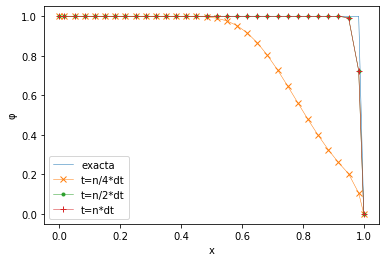

In [26]:
"""
Esquema implícito para la ecuación de conveccion difusion inestacionaria
Discretización espacial con esquema upwind
"""
#matriz de coefs de influencia
M_UI=numpy.zeros((nx,nx))
RHS_I= numpy.zeros((nx, nt))
#discretización temporal
nt = 50 # numero de pasos de tiempo
CFL=.9; Fo=0.25;
umax=numpy.amax(u[:]); Γmax=numpy.amax(Γ); # valores máximos de la velocidad y de la difusividad

dt=min(CFL*dx/umax,Fo*dx**2/Γmax) #paso de tiempo
#dt=10
# array para guardar los resultados  en cada paso de tiempo
φ_sol=numpy.zeros((nx+2, nt))

#condición inicial
φ_i=numpy.zeros((nx+2))

#condición inicial no uniforme
#φ_i = numpy.ones(nx)      #numpy function ones()
#φ_i[int(.5 / dx):int(1 / dx + 1)] = 2

#valores en el contorno
D_0=2*Γ[0]/dx;   D_L=2*Γ[nx+1]/dx; 
F_0=ρ*u[0];    F_L=ρ*u[nx+1];

# BC izquierda

φ_sol[0, :]=φ_0;


u_3o2=(u[0]+u[1])/2  #u_3/2
Γ_3o2=(Γ[0]+Γ[1])/2 
D_3o2=Γ_3o2/dx
F_1o2=0;  F_3o2=ρ*u_3o2;

# BC derecha
φ_sol[nx+1, :]=φ_L;


u_nm3o2=(u[nx-2]+u[nx-1])/2 #u_n-1/2
Γ_nm3o2=(Γ[nx-2]+Γ[nx-1])/2  ## Γ_n-1/2
D_nm3o2=Γ_nm3o2/dx
F_nm3o2=ρ*u_nm3o2;  




for j in range (nt):
    
    # BC izquierda
    u_3o2=(u[0]+u[1])/2  #u_3/2
    Γ_3o2=(Γ[0]+Γ[1])/2 
    D_3o2=Γ_3o2/dx
    F_1o2=0;  F_3o2=ρ*u_3o2;
    
    M_UI[0][0] =-min(F_0, 0)+max(F_3o2,0)+D_3o2+D_0+ρ*dx/dt
    M_UI[0][1]   =-D_3o2- min(F_3o2,0)


    RHS_I[0, j] = (max(0,F_0)+D_0)* φ_0+ρ*dx/dt*φ_sol[0, j-1]
    #ultima fila de la matriz
    u_nm3o2=(u[nx-2]+u[nx-1])/2 #u_n-1/2
    Γ_nm3o2=(Γ[nx-2]+Γ[nx-1])/2  ## Γ_n-1/2
    D_nm3o2=Γ_nm3o2/dx
    F_nm3o2=ρ*u_nm3o2;  

    M_UI[nx-1][nx-1] =max(F_L, 0)-min(F_nm3o2, 0)+D_nm1o2+D_L+ρ*dx/dt
    M_UI[nx-1][nx-2]   =-D_nm1o2-F_nm1o2/2
    
    RHS_I[nx-1,j] = (-max(F_L, 0)+D_L)* φ_L+ρ*dx/dt*φ_sol[nx-1, j-1]
    for i in range(1, nx-1):
        #flujos convectivos
        u_im1o2=(u[i-1]+u[i])/2; u_ip1o2=(u[i]+u[i+1])/2 # u_i-1/2; u_i+1/2
        F_im1o2=ρ*u_im1o2;  F_ip1o2=ρ*u_ip1o2;
        #flujos difusivos
        Γ_im1o2=(Γ[i-1]+Γ[i])/2;  Γ_ip1o2=(Γ[i]+Γ[i+1])/2 
        D_im1o2=Γ_im1o2/dx;     D_ip1o2=Γ_ip1o2/dx;
        
        M_UI[i][i-1] = (-D_im1o2-max(F_im1o2, 0));
        M_UI[i][i+1] = (-D_ip1o2+min(F_ip1o2, 0));
        M_UI[i][i]   =  D_im1o2+D_ip1o2+max(F_im1o2, 0)-min(F_ip1o2, 0)-(F_ip1o2-F_im1o2)+ρ*dx/dt;
        
        RHS_I[i, j]= φ_sol[i, j-1]*ρ*dx/dt                                                                                    
    
    φ_sol[1:nx+1, j]=numpy.linalg.solve(M_UI, RHS_I[:, j])
    
  
#soluciones para distintos instantes

pyplot.plot(x_an, φ_an,  lw=0.5)
pyplot.plot(x_an, φ_sol[: , int(nt/4)],  lw=0.5 , marker='x')
pyplot.plot(x_an, φ_sol[: , int(nt/2)],  lw=0.5 , marker='.')                    
pyplot.plot(x_an, φ_sol[: , nt-1],  lw=0.5 , marker='+')
pyplot.xlabel("x")
pyplot.ylabel("φ")
pyplot.gca().legend(('exacta','t=n/4*dt','t=n/2*dt','t=n*dt'))

# Ecuaciones de Navier Stokes para flujo incompresible

Las Ecs. de Navier Stokes para un flujo incompresible, estacionario y bidimensional se expresan como

$$
\begin{align}
\frac{\partial (\rho u u)}{\partial x} +\frac{\partial (\rho u v)}{\partial y} & =\frac{\partial}{ \partial x}\left( \mu \frac{\partial u}{ \partial x}  \right) +\frac{\partial}{ \partial y}\left( \mu \frac{\partial u}{ \partial y}  \right)-\frac{\partial p}{\partial x}\\
\frac{\partial (\rho u v)}{\partial x} +\frac{\partial (\rho v v)}{\partial y} & =\frac{\partial}{ \partial x}\left( \mu \frac{\partial v}{ \partial x}  \right) +\frac{\partial}{ \partial y}\left( \mu \frac{\partial v}{ \partial y}  \right)-\frac{\partial p}{\partial y}
\end{align}
$$
Si la distribución de presiones en el espacio $p(x,y)$ fuera conocida, entonces se convierten en un término fuente. Las Ecs. de Navier Stokes se convierten entonces en un problema de convección difusión no lineal para las velocidades $u$ y $v$

Sin embargo, debe tenerse en cuenta un detalle importante: si se emplea una celda como la usada para el problema de convección difusión lineal aparecen dos problemas: 
* los flujos en las interfaces dependen de promedios de la variable incógnita
* cuando se evalúa el gradiente de presión es necesario interpolar para obtener la presión en cada interfaz

$$ p_{i+1/2}=\frac{p_{i+1}+p_i}{2} ; \qquad p_{i-1/2}=\frac{p_{i}+p_{i-1}}{2} $$

Evaluando la derivada de la presión respecto a x en el centro de la celda con una diferencia centrada se obtiene

$$ \frac{\partial p}{ \partial x}_{x_i} = \frac{p_{i+1/2} -p_{i-1/2}}{\Delta x}= \frac{p_{i+1} -p_{i-1}}{2\Delta x} $$

Que equivale a una diferencia centrada de orden $\mathcal{O}(\Delta x ^2)$

Sin embargo, si se impone una distribución de presiones  fluctuante de la forma
$$\begin{align}
p_i=& 5  &\text{ para i impar} \\
p_i=& 10  &\text{ para i par}
\end{align}
$$

se obtiene la siguiente distribución de presión y sus derivadas


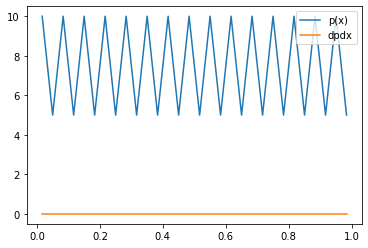

In [27]:
p=numpy.zeros(nx)

for i in range(0, nx, 2):
    p[i]=10
    
for i in range(1, nx, 2):
    p[i]=5
    
pyplot.plot(x, p )

dpdx=numpy.zeros(nx)

for i in range(1,nx-1):
    p_im1o2=(p[i-1]+p[i])/2
    p_ip1o2=(p[i]+p[i+1])/2
    dpdx[i]=(p_ip1o2-p_im1o2)/2/dx

pyplot.plot(x, dpdx)
pyplot.legend(('p(x)', 'dpdx'))

## Mallas _staggered_, o escalonadas o alternadas

Para solucionar dicho inconveninente se emplean discretizaciones distintas para las variables vectoriales (componentes de las  velocidades) y para las variables escalares (presiones, densidades, viscosidades, etc).
Los centros de las celdas de velocidades coinciden con las interfaces de las celdas de presión. Si se trata de una discretización estructurada con paso constante ambos tipos de  celdas se encuentran desplazadas entre sí $\Delta x/2$

 ![title](figs/vol_de_cont_staggered.png)
 
 De esta manera, las velocidades quedan directamente definidas en las interfaces de las celdas de presión, y no es necesaria ninguna interpolación para calcular el cambio de presión. Lo mismo ocurre con las presiones, quedan en las interfaces de las celdas de velocidad, por lo tanto no se necesita interpolación para evaluar el gradiente de presión en la celda. El mismo resulta
 
 $$ \frac{\partial p}{ \partial x}_{x_{i+1/2}} = -\frac{p_{i+1} -p_{i}}{\Delta x} $$
 ### Ecuación de cantidad de movimiento en x  integrada en una celda

Integrando en el volumen de control delimitado por una celda de velocidad  y aplicando teorema de la divergencia para los flujos convectivos y difusivos se obtiene:

$$ \int_\mathcal{V} \frac{\partial \rho u}{\partial t} d\mathcal{V}+ \oint_{S.C.}( \rho V_j u  ) \hat{n} dA = \oint_{S.C.}\left(  \mu \frac{\partial u_i}{\partial x}\right)\hat{n} dA +\int_{V} \frac{\partial p}{\partial x} d \mathcal{V} $$
donde $V_j$ es el vector velocidad y $\mathcal{V}$ es el volumen de la celda. Para el caso unidimensional $V_j=u$

Si el flujo es estacionario, el primer término se anula
$$   ( \rho V_j )_{i+1}A_{i+1}u_{i+1}-( \rho V_j )_{i}A_{i}u_{i} = \left(   \frac{ u_{i+1/2}-u_{i-1/2}}{\Delta x}\right)\mu_{i-1} A_{i} -\left(   \frac{ u_{i-1/2}-u_{i-3  2}}{\Delta x}\right) \mu_{i-1} A_{i-1} +  \frac{\partial p}{\partial x} \mathcal{V} $$

 
 La Ec. de conservación para la velocidad $u_{i+1/2}$ resulta entonces
$$\begin{align}
 \left( \rho u \right)_{i+1}   u_{i+1} -\left( \rho u \right)_i u_{i}=&   \left( \mu  \right )_{i+1}  \frac{\partial u}{\partial x}_{i+1}- \left( \mu \right)_{i} \frac{\partial u}{\partial x}_{i+1} +  \frac{\partial p}{\partial x} \mathcal{V}_i\\
 F_{i+1}   u_{i+1} -F_i u_{i}=&   \left(D  \right )_{i+1}  (u_{i+3/2} -u_{i+1/2})- \left(D \right)_{i} (u_{i+1/2} -u_{i-1/2}) \frac{ p_i -p_{i+1}}{\Delta x} \mathcal{V}_i \\
\end{align}
$$

Los flujos convectivos en las interfaces $i$ se evalúan promediando los valores de los flujos en donde las velocidades son conocidas  (es decir en las interfaces $i+1/2$) de la siguiente manera

$$ F_i =\left( \rho u \right)_i = \frac{F_{i+1/2}+F_{i-1/2}}{2} $$

El flujo en la interfaz $i+1/2$se obtiene promediando la densidad (y cualquier otro escalar variable) que no esté definido en dicha interfaz
 $$ F_{i+1/2} = \frac{\rho_{i+1}+\rho_{i}}{2}u_{i+1/2} $$
 
 Reemplazando esta expresión y su análoga en $F_i$
 
 $$ F_i = \frac{1}{2} \left[ \frac{\rho_{i+1}+\rho_{i}}{2}u_{i+1/2}+\frac{\rho_{i}+\rho_{i-1}}{2}u_{i-1/2}\right]  $$
 
 Los flujos difusivos se evalúan directamente con el valor de $\mu$ en la interfaz, que es conocido
 
 $$ D_{i}= \frac{\mu_{i}}{\Delta x}$$
 
 Por último, resta definir  los velores de $u$ en las caras del volumen de control. Para ello se usa cualquier esquema de discretización de la Ec. de convección difusión. Si se empleara esquema Upwind resultaría
 
  $$ \begin{align}
  u_{i+1} =u_{i + 1/2};\quad &  u_{i} =u_{i - 1/2} & \text{si } u>0 \\ 
  u_{i+1} =u_{i + 3/2}; \quad &  u_{i} =u_{i + 1/2} & \text{si } u<0
  \end{align}
  $$
  
  La Ec. de conservación para la velocidad $u_{i+1/2}$ se reduce a 
  
  $$ \begin{multline} \left[ D_{i+1}+D_{i}+max(F_i, 0)-min(F_{i+1}, 0)-(F_{i+1}-F_i)\right] u_{i+1/2}+\left[ -D_{i+1}+min(F_{i+1}, 0)\right] u_{i+3/2} \dots \\
  +\left[  -D_{i-1}-max(F_{i-1}, 0) \right]u_{i-1/2} =-\frac{ (p_{i+1}-p_{i})A_{i+1/2} \Delta x}{\Delta x} \end{multline}$$
 Reemplazando el volumen de la celda $\mathcal{V}_i =A_{i+1/2} \Delta x $
  Llamando a los coeficientes de las $u_j$
  $$\begin{align} 
  a_{i+1/2}^{(u)}&=D_{i+1}+D_{i}+max(F_i, 0)-min(F_{i+1}, 0)-(F_{i+1}-F_i)   \\
  a_{i-1/2}^{(u)}&=-D_{i-1}-max(F_{i-1}, 0)\\
  a_{i+3/2}^{(u)}&=-D_{i+1}+min(F_{i+1}, 0)
  \end{align}
  $$
   Se expresa el sistema de ecuaciones de manera más compacta
   
  $$  \begin{equation} a_{i+1/2}^{(u)}u_{i+1/2}+a_{i+3/2}^{(u)} u_{i+3/2}
  +a_{i-1/2}^{(u)}u_{i-1/2} = (p_{i}-p_{i+1})A_{i+1/2}  
  \end{equation}$$
  
  De esta manera pueden resolverse las componentes de la velocidad en función de la distribución de presiones en el campo de movimiento. Sin embargo, generalmente la distribución de presiones no es conocida y se encuentra acoplada a la distribución de velocidades. Por ello es necesario encontrar una ecuación para resolver la distribución de presiones conocido el campo de velocidades. 
  
  ## Ecuación para la presión
  
  La Ec. de continuidad en dos dimensiones se expresa como:
  
  $$ \begin{equation}
  \frac{\partial \rho u}{\partial x} +\frac{\partial \rho v}{\partial x}=0
  \end{equation}$$
  
  En esta ecuación no aparece la presión de manera explícita, luego es necesario modificarla para obtener una ec. adicional para la presión. Tomando la divergencia a las ecs de conservación de cantidad de movimento (que equivale a derivar la componente en x resp a x y la componente en y resp a y y sumarlas) se obtiene una ecuación con el laplaciano de la presión. Escribiento las ecs de navier stokes en notación indicial, donde $V_j=[u, v]$ y $x_i=[x, y]$ :
$$     \begin{equation}
  \frac{\partial \rho V_i V_j}{\partial x_i} =\frac{\partial}{ \partial x_i}\left( \mu \frac{\partial V_j}{ \partial x_i}  \right) -\frac{\partial  p}{\partial x_j}
  \end{equation} $$
  
 Tomando la divergencia a dicha ecuación  y teniendo en cuenta que $\frac{\rho \partial V_i}{\partial x_i}=0$ por la ec. de continuidad se obtiene
 $$     \begin{align}
  \frac{\partial}{\partial x_j}\frac{\partial \rho V_i V_j}{\partial x_i} &= \frac{\partial}{\partial x_j}\frac{\partial}{ \partial x_i}\left( \mu \frac{\partial V_j}{ \partial x_i}  \right) -\frac{\partial}{\partial x_j}\frac{\partial  p}{\partial x_j}\\
  \frac{\partial}{\partial x_j} \left[\rho V_i \frac{\partial V_j}{\partial x_i}\right] &=  -\frac{\partial^2   p}{\partial x_j^2}\\
  \end{align} $$
  
  Se obtiene entonces una ecuación de Poisson para la presión, donde el miembro izquierdo sólo depende de la parte convectiva. 
  $$\frac{\partial^2   p}{\partial x_j^2}  =  -\frac{\partial}{\partial x_j} \left[\rho V_i \frac{\partial V_j}{\partial x_i}\right]
  $$
  
  Hay distintas formas de implementar esta Ec. de forma discreta: una de ellas es calcular el operador convectivo numéricamente y reemplazarlo en el miembro derecho. Otra de ellas es despejar los valores de las componentes de las velocidades en función de la presión y reemplazarlas en dicha ecuación. Dependiendo del método se emplea una formulación u otra

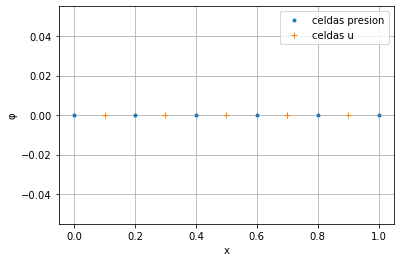

In [4]:

"""
Estructura de datos y discretizacion espacial

"""
nx=5
dx=L/nx
x_vel = numpy.linspace(dx/2, L-dx/2, nx) # para el cálculo numérico
x_pres=numpy.linspace( 0, L, nx+1)

pyplot.plot(x_pres, numpy.zeros(nx+1),  lw=0.0 , marker='.')                    
pyplot.plot(x_vel, numpy.zeros(nx),  lw=0.0 , marker='+')
pyplot.xlabel("x")
pyplot.ylabel("φ")
pyplot.gca().legend(('celdas presion','celdas u'))
pyplot.grid(b=None, which='major', axis='both')


## Condiciones de contorno

Para definir el problema completamente es necesario definir condiciones de contorno. Existen diversos formas y combinaciones de las mismas. Las más comunes son:

- entrada de velocidad (_velocity inlet_) : se impone una velocidad o un caudal másico en la región de entrada. Puede ser con las componentes del vector velocidad, o en la dirección de la normal a la superficie de entrada considerada. Es decir, se crea un nodo fantasma fuera del dominio de cálculo donde se establece $u= u_{in}$, $v= v_{in}$ $\phi= \phi_{in}$. La presión en la celda adjacente en la entrada no se conoce, por ende debe calcularse en función de la velocidad de entrada y las condiciones aguas abajo.

- entrada de presión (_pressure inlet_):En este caso se impone un valor de la presión en la superficie de entrada. Puede ser una presión estática o bien una presión de estancamiento. En caso de conocerse la presion estática la velocidad en la celda aguas arriba se obtiene mediante la Ec. de continuidad en función de los valores de las celdas aguas abajo y se agrega en la ec. de conservación de cantidad de movimiento:
$$u_{in}=\frac{\sum A_{ij}u_j}{A_{in}}$$
En caso de que se trate de una presión de estancamiento $p_{st}$ se obtiene el valor de la presión estática con la Ec. de Bernoulli
$$p_{in}=p_{st\, in}-\frac{\rho u_{in}}{2}$$

- Salida de presión (_pressure outlet_). Se establece un valor constante para la presión aguas abajo.

# Algoritmo SIMPLE

El algoritmo SIMPLE es un algoritmo desarrollado por Patankar y Spalding en 1971 para resolver problemas de flujo incompresible estacionario. SIMPLE es un acrónimo para _Semi-Implicit Method for Pressure Linked Equations_. El método consiste en resolver las ecuaciones de cantidad de movimiento y de presión de manera desacoplada y secuencial (i.e., primero resolviendo las componentes de la velocidad para luego reemplazarlas en la ecuación de la presión, y así obtener una corrección).

Como se trata de un problema no lineal (ya que los flujos convectivos dependen de u), se proponen una distribución inicial de presión y velocidad  $p^n$ y $u^n$ respectivamente, para la $n-ésima$ iteración. En caso de ser la primera iteración el usuario debe definirlas, como si fuera una condición inicial. Para otra iteración se adopta el valor obtenido en la anterior. 

Se propone obtener la velocidad  y la presión  como la suma de:
1. un valor obtenido con un paso predictor ($u^*$ y $p^*$) resolviendo las ecs. de cantidad de movimiento y masa evaluando los flujos en  $p^n$ y $u^n$
2. las correcciones $u'$ y $p'$ respectivamente, obtenidas con los valores de  ($u^*$ y $p^*$) previamente calculados

$$\begin{align} \label{eq: corr_u}
u^{n+1}=& u^*+ u'\\
p^{n+1}=& p^* +p' \nonumber
\end{align}
$$



## Determinación de la velocidad
Evaluando los flujos convectivos con las velocidades $u^n_i$ propuestas en la Ec de cant. de movimiento, y asumiendo que  los valores propuestos de la presión $p^n=p^*$, se obtiene un sistema de Ecs. implícito en las componentes $u^*_{i+k}$, donde $k$ son los elementos vecinos a la celda considerada según la función de flujo elegida. Resolviendo el sistema se obtiene un valor corregido de $u^*$

  $$  a_{i+1/2}^{(u)}u^*_{i+1/2}+a_{i+3/2}^{(u)} u^*_{i+3/2}
  +a_{i-1/2}^{(u)}u^*_{i-1/2} = \frac{(p^n_{i}-p^n_{i+1})A_{i+1/2}}{\Delta x} $$
  
  Por otro lado, puede despejarse el valor de $u^*_{i+1/2}$ en el centro de cada celda como
  
  
$$ \begin{equation} u^*_{i+1/2} = \frac{(p^*_{i}-p^*_{i+1})A_{i+1/2}}{a_{i+1/2}^{(u)}.\Delta x}-\frac{a_{i-1/2}^{(u)}}{a_{i+1/2}^{(u)}}u^*_{i-1/2}-\frac{a_{i+3/2}^{(u)}}{a_{i+1/2}^{(u)}} u^*_{i+3/2} \end{equation} $$

Esta ecuación también es válida cuando se evalúa en la velocidad exacta $u$, asumiendo que la corrección $u'$ es pequeña

$$ \begin{equation} u_{i+1/2} = \frac{(p_{i-1}-p_{i})A_{i+1/2}/dx}{a_{i+1/2}^{(u)}}-\frac{a_{i-1/2}^{(u)}}{a_{i+1/2}^{(u)}}u_{i-1/2}-\frac{a_{i+3/2}^{(u)}}{a_{i+1/2}^{(u)}} u_{i+3/2}\end{equation} $$

Restando miembro a miembro ambas ecuaciones y teniendo en cuenta la definición   (1) se obtiene una ecuación para las correcciones de la velocidad

$$ \begin{equation} u'_{i+1/2} = \frac{(p'_{i}-p'_{i+1})A_{i+1/2}/dx}{a_{i+1/2}^{(u)}}-\frac{a_{i-1/2}^{(u)}}{a_{i+1/2}^{(u)}}u'_{i-1/2}-\frac{a_{i+3/2}^{(u)}}{a_{i+1/2}^{(u)}} u'_{i+3/2}\end{equation} $$

Si además se asume que $\frac{a_{i-1/2}^{(u)}}{a_{i+1/2}^{(u)}}<<1$ y $\frac{a_{i+3/2}^{(u)}}{a_{i+1/2}^{(u)}}<<1$
puede obtenerse el valor exacto de la velocidad en cada celda en función de la corrección de la presión

$$\begin{equation}
u^{n+1}_{i+1/2}= u^*_{i+1/2}+ \frac{(p'_{i}-p'_{i+1})A_{i+1/2}}{a_{i+1/2}^{(u)}}
\end{equation}
$$
Siendo  la corrección a la velocidad $u'_{i+1/2}= \frac{(p'_{i}-p'_{i+1})A_{i+1/2}}{a_{i+1/2}^{(u)}}$. Además,  
por simplicidad se llama $d_{i+1/2}=\frac{A_{i+1/2}}{{a_{i+1/2}^{(u)}}}$

## Determinación de la presión

Para obtener una ecuación para la presión recurrimos a la única ecuación disponible: la conservación de la masa.
Empleando la celda escalar para la conservación de la masa discreitizada se obtiene

$$ \rho_{i+1/2}A_{i+1/2}u_{i+1/2}- \rho_{i-1/2}A_{i-1/2}u_{i-1/2}=0  $$

Reemplazando el valor de $u_{i+1/2}$ dado por la Ec. (5) se obtiene

$$ \rho_{i+1/2}A_{i+1/2}\left[ u^*_{i+1/2}+ d_{i+1/2}(p'_{i}-p'_{i+1})\right]- \rho_{i-1/2}A_{i-1/2}\left[ u^*_{i-1/2}+ d_{i-1/2}(p'_{i-1}-p'_{i})\right]=0  $$

Esta  ecuación puede reescribirse como un sistema de ecuaciones cuyas incógnitas son las correcciones para la presión $p'_i$


$$\begin{equation}
\left[  \rho_{i+1/2}A_{i+1/2} d_{i+1/2}+\rho_{i-1/2}A_{i-1/2}d_{i-1/2}\right] p'_{i} + \left[  -\rho_{i+1/2}A_{i+1/2} d_{i+1/2}\right]p'_{i+1}+\left[- \rho_{i-1/2}A_{i-1/2}  d_{i-1/2}\right]p'_{i-1}=\rho_{i-1/2}A_{i-1/2}u^*_{i-1/2}-\rho_{i+1/2}A_{i+1/2}u^*_{i+1/2}
\end{equation}$$

Puede verse que el miembro derecho de la ecuación representa el balance de flujo másico a través de la celda para la velocidad predicha con el campo de presiones propuesto $p^*$. Si el valor propuesto no es el exacto, entonces el campo de velocidades tampoco lo es y aparece un desbalance en los flujos másicos. 

Una vez determinadas las correcciones de la presión se reemplazan en las Ecs.(5)  y (1) para obtener una nueva estimación de la velocidad  y la presión.
Para determinar la convergencia es necesario tomar alguna norma de los vectores con la solución de la presión y la velocidad. Normalmente se toma la norma euclideana, o $L_2$.
Se comparan los residuos de la velocidad y de la presión:

$$ \begin{align}
\mathcal{R}_{L_2}^{(u)} &=\left[\sum_{i=0}^n \left( \frac{u_{i+1/2}^{act}-u_{i+1/2}^{ant}}{u_{i+1/2}^{act}}
\right)^2 \right]^{1/2}\\
\mathcal{R}_{L_2}^{(p)} &=\left[\sum_{i=0}^n \left( \frac{p_i^{act}-p_i^{ant}}{p_i^{act}}
\right)^2 \right]^{1/2}\\
\end{align}
$$
Si el valor de ambos es menor que la tolerancia establecida, se suspende el cálculo. Sino, se hace
$$u_{i+1/2}^{n+1}=u_{i+1/2}^{*}+u_{i+1/2}';\qquad p_{i}^{n+1}=p_{i}^{*} +p_i'
$$
y se vuelve a comenzar el cálculo, pasando a la iteración siguiente. 

## Factores de subrelajación


Existen ocasiones en que la convergencia no es robusta, y el método presenta oscilaciones en su curva de residuos. Para ello se introduce una corrección a la baja en la corrección de celocidad y presión. Definiendo los factores de subrelajación para la velocidad  y presión respectivamente $\alpha_u$ y $\alpha_p$, se obtiene

$$ \begin{align}
p^{n+1}& = p^n+\alpha_p p'\\
u^{n+1} & = \alpha_u (u^*+u')-(1-\alpha_u)u^{n}
\end{align}$$

De esta manera, si $\alpha_u=\alpha_p=0$ entonces el método no actualiza nunca el valor de $p^n$ y $u^n$, y si $\alpha_u=\alpha_p=1$ se obtiene el método original sin corrección. 

Los factores de subrelajación introducen algo similar a la difusión artificial, evitando oscilaciones debidas a grandes variaciones en las correcciones. De hecho, se demuestra que la Ec. para la velocidad se reduce a

$$ \begin{equation}\frac{a_{i+1/2}^{(u)}}{\alpha_u} u^{n+1}_{i+1/2} = (p_{i-1}-p_{i})A_{i+1/2}-a_{i-1/2}^{(u)}u^{n+1}_{i-1/2}-a_{i+3/2}^{(u)} u^{n+1}_{i+3/2} +\left[ (1- \alpha_u)\frac{a_{i+1/2}^{(u)}}{\alpha_u}  \right] u_{i+1/2}^{n}\end{equation} $$

Es decir, el factor $\alpha_u $ cumpliría un rol análogo al del CFL, a pesar de no ser un proceso de integración temporal, sino de iteración para solución de un sistema no lineal. 
## Condiciones de contorno

- _pressure inlet_: En caso de tener un inlet con la presión fijada la Ec. para la celda del contorno resulta

$$ F_1u^*_{1/2}-F_0u^*_{0}=(p_0-P_1)A_{1/2} $$
reemplazando el valor de u_0 dado por la Ec. de cont entre 1/2 y 0 y considerando un dominio 1D
$$u^*_0=u^*_{1/2}A_{1/2}/A_0$$

$$ (F_1-F_0 A_{1/2}/A_0)u_{1/2}=(p_0-P_1)A_{1/2} $$
Vemos que esto introduce un término  negativo al coeficiente $a_{1/2}$, luego se opta por pasarlo como término fuente al miembro derecho con el valor de $u^n$

$$ F_1u^*_{1/2}=(p_0-P_1)A_{1/2}+F_0 A_{1/2}/A_0)u^n_{1/2} $$
En caso de conocerse la presión de estancamiento se reemplaza  su valor

$$ \begin{equation} F_1 u^*_{1/2}=(p_{st \,0} -\frac{\rho_{1/2}[u^*_{1/2}A_{1/2})]^2}{2 A_0^2}-P_1)A_{1/2}+F_0 A_{1/2}/A_0)u^n_{1/2} \end{equation}$$

- _pressure outlet_ : En este caso como la presión es conocida en el contorno, se hace simplemente $p'_{out}=0$

### Ejemplo de Aplicación

Se aplicará el algoritmo SIMPLE a un caso de flujo unidimensional con cambio de área: una tobera convergente de 2 metros de longitud que descarga un gas de densidad $\rho=1 \frac{kg}{m^3}$. 

Se conoce la ley de variación del área y las presiones en la entrada y salida de la misma son conocidas: 
- en la salida la presión es ambiente
- en la entrada se conoce que **la presión de estancamiento** es de 10 Pa (manométrica)


![title](figs/tobera_geo.png)

Para resolver este caso usamos una discretización con cuatro celdas para la velocidad, como se muestra en la Fig

![title](figs/tobera.png)

las celdas de velocidad se muestran en rojo. De esta manera, aplicando el principio de malla colocada, obtenemos cinco celdas para la presión. La primera y la última tienen valores definidos por las condiciones de contorno, luego quedan tres incógnitas de presión.

Proponemos una distribución de presiones que varía linealmente a lo largo de la tobera 
$$ p(x) = p_0 +\frac{p_L-p_0}{L}x $$
La distribución de velocidades se obtiene proponiendo un caudal másico constante de $\dot{m}=1 kg/s$
$$ u_j =\frac{\dot m}{\rho_j A_j}$$

Se asume además que el flujo es invíscido. 


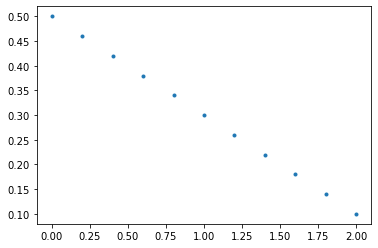

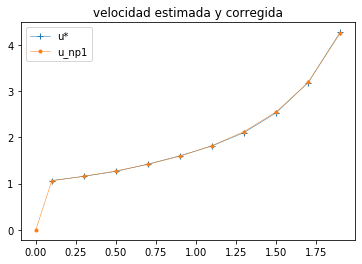

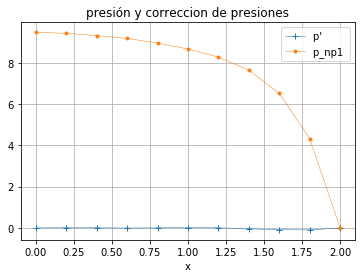

In [33]:

import numpy
from matplotlib import pyplot
"""
solución de ec. de navier stokes 1D por el esquema simple
"""
ni=50 #número de iteraciones

L=2 #longitud
nx=10 #número de nodos en x
dx=L/nx

# Factores de subrelajacion para presion y velocidad

alfap=0.1; alfav=0.7;


p_inf=10; #presión de estancamiento en extr izq
pL=0; #presión manométrica en la salida

"""
vectores de parámetros
"""
ρ=numpy.ones(nx+1)#ditribucion de densidad
μ=numpy.ones(nx+1)*0 #viscosidad 
A=numpy.ones(nx+1) #distribución de areas
d= numpy.ones(nx)

"""
discretización espacial
"""
A0=0.5;  AL=0.1;

x_vel = numpy.linspace(dx/2, L-dx/2, nx) # para el cálculo numérico
x_vel=numpy.append([0], x_vel);
 
x_pres=numpy.linspace( 0, L, nx+1)

A[:]=A0+(AL-A0)/L*x_pres[:]

"""
    Guess inicial para presión y velocidad
"""
p=numpy.zeros((nx+1,ni+1)) # campo de presiones
u=numpy.zeros((nx+2,ni+1)) # campo de velocidades

u[1:nx+1, 0]= 1/(ρ[1:nx+1]*(A[0:nx]+A[1:nx+1])/2) # condicion inicial de versteeg 
#asumiendo caudal másico unitatio
p[:,0]=p_inf+(pL-p_inf)/L*x_pres #interpolación lineal para p inicial
#pprime=numpy.ones(nx+1,ni)# corrección al campo de presiones propuesto 
#uprime=numpy.ones(nx+1,ni)# corrección al campo de velocidades propuesto 

#pyplot.plot(x_vel[1:nx+1], u[1:nx+1,0],  lw=0.0 , marker='x')                    
#pyplot.plot(x_pres, p[:,0],  lw=0.0 , marker='x')
pyplot.figure(0)
pyplot.plot(x_pres, A,  lw=0.0 , marker='.')                    
#pyplot.plot(x_pres, μ,  lw=0.0 , marker='+')
#pyplot.xlabel("x")
#pyplot.ylabel("φ")
#pyplot.gca().legend(('U','P'))#('area','visc'))
#pyplot.grid(b=None, which='major', axis='both')

"""
condiciones de contorno
"""




#contorno izquierdo
#p[0,:]=p0; 
#pprime[0,:]=0; 
#u[0, :]=0;
#contorno derecho
#p[nx,:]=pL; 
#pprime[0,:]=0; 
"""
bucle principal de iteraciones
"""

for k  in range(ni):
    """
    asignación de memoria para variables
    """

    M_vel=numpy.zeros((nx, nx)) # matriz de coefs de influencia para la velocidad u
    RHS_vel=numpy.zeros(nx)
    F_i=numpy.zeros(nx)
    F_ip1=numpy.zeros(nx)
    
    M_p=numpy.zeros((nx-1, nx-1)) # matriz de coefs de influencia para la presion
    RHS_p=numpy.zeros(nx-1)
    """
    sistema de ecuaciones para la velocidad empleando el esquema upwind
    """
# convención de índices 
#se usa I para la velocidad, donde I=i+1/2

    for i in range(1, nx-1):
    #flujos convectivos en los centros de las celdas de velocidad
        I=i #se usa I para la velocidad, donde I=i+1/2
        A_ip1o2=(A[i]+A[i+1])/2.0; 
        F_ip3o2=(ρ[i+2]+ρ[i+1])/2.0 *u[I+2,k];
        F_ip1o2=(ρ[i]+ρ[i+1])/2.0 *u[I+1,k];
        F_im1o2=(ρ[i]+ρ[i-1])/2.0 *u[I,k];  
        #F_im3o2=(ρ[i-1]+ρ[i-2])/2.0 *u[I-1,k]; 
        
        #flujos en las interfaces en celdas de velocidad
        F_i [i] = (F_ip1o2+F_im1o2)/2.0*A[i]
        F_ip1[i] =(F_ip3o2+F_ip1o2)/2.0*A[i+1]
        
        #print(" i= %d, F_i= %6f, F_ip1=%6f" % (i, F_i[i] , F_ip1[i]))
        #F_im1 =(F_im1o2+F_im3o2)/2.0*A[i-1]
        #flujos difusivos
    
        D_im1=μ[i-1]*A[i-1]/dx;     D_i=μ[i]*A[i]/dx; D_ip1=μ[i+1]*A[i+1]/dx;
    
        M_vel[i][i-1] = (-D_i-max(F_i[i], 0));# coef a_i-1/2
        M_vel[i][i+1] = (-D_ip1+min(F_ip1[i], 0)); # coef a_i+3/2
        M_vel[i][i]   =  D_i+D_ip1+max(F_i[i], 0)-min(F_ip1[i], 0)+(F_ip1[i]-F_i[i]);
        d[i]=A_ip1o2/M_vel[i][i]
        RHS_vel[i]=(p[i, k]-p[i+1,k])*A_ip1o2#/dx

    #valores en el contorno
    
    #se asume condición de far field en el extremo izquierdo
    u[0, k]=u[1, k]*(A[0]+A[1])/2/A[0]
    p[0,k]=p_inf-1/2*ρ[0]*u[0,k]**2
    D_0=2*μ[0]*A[0]/dx;    
    F_0=ρ[0]*u[0, k]*A[0];   

    # BC izquierda
    #u_3o2=(u[0, k]+u[1, k])/2  #u_3/2
    A_1o2=(A[0]+A[1])/2
    D_1=μ[1]*A[1]/dx
    F_1o2=(ρ[0]+ρ[1])/2*u[1,k];  F_3o2=(ρ[1]+ρ[2])/2*u[2, k];
    F_1=(F_1o2+F_3o2)/2*A[1]

   # print(" i= %d, F_i= %6f, F_ip1=%6f" % (0, F_0 , F_1))
    M_vel[0][0] =-min(F_1, 0)+max(F_0,0)+D_1+D_0+(F_1-F_0)+F_0*(A_1o2/A[0])**2/2
    M_vel[0][1]   =-D_1- min(F_1,0)
    d[0]=A_1o2/M_vel[0, 0]
    
    
    RHS_vel[0] = (p_inf-p[1,k])*A_1o2+F_0*u[0, k]#/dx
    
    # BC derecha
    A_nm1o2=(A[nx]+A[nx- 1])/2
    #ultima fila de la matriz
    D_L=2*μ[nx]*A[nx]/dx; 
    u[nx+1, k]=u[nx, k]*A_nm1o2/A[nx]
    F_L=ρ[nx]*A[nx]*u[nx+1, k];
    #u_nm3o2=(u[nx-2]+u[nx-1])/2 #u_n-1/2
    
    
    D_nm1=μ[nx-1]*A[nx-1]/dx
    F_nm1o2=(ρ[nx-1]+ρ[nx])/2*u[nx,k];
    F_nm3o2=(ρ[nx-2]+ρ[nx-1])/2*u[nx-1,k];
    F_nm1= (F_nm3o2+F_nm1o2)/2*A[nx-1]
   # print(" i= %d, F_i= %6f, F_ip1=%6f" % (4, F_nm1 , F_L))
    
    M_vel[nx-1][nx-1] =max(F_nm1, 0)-min(F_L, 0)+D_nm1+D_L+(F_L-F_nm1)
    M_vel[nx-1][nx-2]   =-D_nm1-F_nm1
    d[nx-1]=A_nm1o2/M_vel[nx-1][nx-1]
    RHS_vel[nx-1] = (p[nx-1, k]-p[nx, k])*A_nm1o2#/dx


    u_star=numpy.linalg.solve(M_vel, RHS_vel) #nuevo valor de u* despuès de desolver la ec. de cant de mov


    """
    cálculo de la corrección de la presión
    """
    ρ_3o2=(ρ[1]+ρ[2])/2 
    ρ_1o2=(ρ[0]+ρ[1])/2
    A_1o2=(A[1]+A[0])/2; A_3o2=(A[1]+A[2])/2; 
    M_p[0][1] = -ρ_3o2*A_3o2*d[1];
    M_p[0][0]   =  ρ_3o2*A_3o2*d[1]+ρ_1o2*A_1o2*d[0];
    RHS_p[0]=ρ_1o2*A_1o2*u_star[0]-ρ_3o2*A_3o2*u_star[1]

    ρ_nm3o2=(ρ[nx-1]+ρ[nx-2])/2 
    ρ_nm1o2=(ρ[nx-1]+ρ[nx])/2
    A_nm1o2=(A[nx-1]+A[nx])/2; A_nm3o2=(A[nx-1]+A[nx-2])/2; 
    
    M_p[nx-2 , nx-3] = -ρ_nm3o2*A_nm3o2*d[nx-2];
    M_p[nx-2, nx-2]   =  ρ_nm3o2*A_nm3o2*d[nx-2]+ρ_nm1o2*A_nm1o2*d[nx-1];
    RHS_p[nx-2]=-ρ_nm1o2*A_nm1o2*u_star[nx-1]+ρ_nm3o2*A_nm3o2*u_star[nx-2]


    for i in range(1, nx-2):
    #flujos convectivos en las interfaces de las celdas de presión
        I=i

        ρ_ip1o2=(ρ[i]+ρ[i+1])/2 
        ρ_ip3o2=(ρ[i+2]+ρ[i+1])/2   
        A_ip3o2=(A[i+2]+A[i+1])/2; A_ip1o2=(A[i]+A[i+1])/2;
    #flujos difusivos
    
        M_p[i][i-1] = -ρ_ip1o2*A_ip1o2*d[i];
        M_p[i][i+1] = -ρ_ip3o2*A_ip3o2*d[i+1];
        M_p[i][i]   =  ρ_ip3o2*A_ip3o2*d[i+1]+ρ_ip1o2*A_ip1o2*d[i];
    
        RHS_p[i]= ρ_ip1o2*A_ip1o2*u_star[i]-ρ_ip3o2*A_ip3o2*u_star[i+1]
    p_prime=numpy.linalg.solve(M_p, RHS_p)
    p_prime=numpy.append([0], p_prime); p_prime=numpy.append( p_prime, [0])
    
    p[:, k+1]=(1-alfap)*p[:, k]+alfap*(p[:, k]+p_prime)
    
    
    u[1:nx+1, k+1]=(1-alfav)*u[1:nx+1, k]+alfav*(u_star[0: nx]+(p_prime[0:nx]-p_prime[1:nx+1])*d[0:nx])
    p[0, k+1]=p_inf-0.5*ρ[nx]*u[1, k+1]**2*((A[0]+A[1])/2/A[0])**2

pyplot.figure(1)  
pyplot.plot(x_vel[1:nx+1], u_star,  lw=0.5 , marker='+')                   
pyplot.plot(x_vel, u[0:nx+1, ni],  lw=0.5 , marker='.')
pyplot.title("velocidad estimada y corregida")
pyplot.gca().legend(('u*','u_np1'))

pyplot.figure(2)
pyplot.plot(x_pres, p_prime,  lw=0.5 , marker='+')
pyplot.plot(x_pres, p[:, ni],  lw=0.5 , marker='.')
pyplot.xlabel("x")
#pyplot.ylabel("φ")
pyplot.gca().legend(("p' " ,"p_np1 "))
pyplot.title("presión y correccion de presiones")
pyplot.grid(b=None, which='major', axis='both')


# Algoritmo PISO para solución de las Ecs. de Navier Stokes

El nombre PISO  es un acrónimo de _Pressure Implicit Splitting of Operators_ , es un esquema multipaso desarrollado por R. Issa en 1986 para resolver flujos incompresibles o compresibles estacionarios o inestacionarios. 

El método resuelve de manera discreta el sistema de leyes de conservación  dado en notación indicial por

$$\begin{align}
\frac{\partial \rho }{\partial t} + \frac{\partial \rho u_i }{\partial x_i}  &=0 \\
\frac{\partial \rho u_i }{\partial t} + \frac{\partial \rho u_j u_i }{\partial x_j}  &=-\frac{\partial p}{\partial x_i}+\frac{\partial}{\partial x_j} \sigma_{ij} \\
 \frac{\partial \rho e }{\partial t} + \frac{\partial \rho u_j e }{\partial x_j}  &=\frac{\dot{  \partial q_j}}{\partial x_j}-\frac{\partial p u_j}{\partial x_j}+\frac{\partial}{\partial x_j} u_i \sigma_{ij}
\end{align}
$$

El requisito para resolver flujos compresibles es que la Ec. de estado pueda expresarse de la forma

$$ \begin{equation}
\rho=p \phi(p, t)
\end{equation}$$

donde $\phi$ es la llamada _función de compresibilidad_, que en general es función de la presión y la temperatura. Para un gas ideal es igual a 
$$ \phi= \frac{1}{RT}$$

Las ecuaciones se expresan en función de las variables primitivas $p$, $u_i$ y  $\rho$, lo cual hace que el método no esté bien condicionado para resolver problemas de ondas de choque o discontinuidades. 

Como se trata de un problema no lineal, debe ser resuelto iterativamente hasta llegar a convergencia. Sin embargo, el autor demostró que con un esquema de un paso predictor y dos pasos  correctores se obtiene un error de truncamiento suficientemente aceptable. En cada uno de los pasos mencionados se obtienen valores intermedios de las variables del problema, que se usan para corregir las subsiguientes.   El algoritmo se resume en los siguientes pasos
1. se define la condición inicial ($p^{(n)}$, $u_i^{(n)}$, $\rho_i^{(n)}$  el estado en el paso de tiempo anterior
2. Se determina un campo de velocidades $u_i^{*}$ mediante integración implícita en función de $p^{(n)}$ con la Ec. de cant. de Mov.
3. Se obtiene un nuevo valor intermedio para la presión $p^{*}$ con $u_i^{*}$ con la Ec. de la presión.
4. Se obtiene un nuevo valor intermedio para la velocidad $u_i^{**}$ con $p^{*}$ 
4. Se obtiene un nuevo valor intermedio para la presión $p^{**}$ con $u_i^{**}$
4. Se obtiene un nuevo valor intermedio para la velocidad $u_i^{***}$ con $p^{**}$


## Flujo Incompresible

En el caso de que el flujo sea incompresible la Ec. de la energía se encuentra desacoplada de las Ecs. de continuidad y Cantidad de Movimiento.El sistema de leyes de conservación se reduce a:

$$\begin{align}
 \frac{\partial  u_i }{\partial x_i}  &=0 \\
\rho \frac{\partial  u_i }{\partial t} +\rho \frac{\partial  u_j u_i }{\partial x_j}  &=-\frac{\partial p}{\partial x_i}+\frac{\partial}{\partial x_j} \sigma_{ij} 
\end{align}
$$

De esta manera, es necesario determinar el campo de presiones de una ecuación obtenida de combinar la Ec. de continuidad y la de Cant. de Mov. 
### Ecuaciones discretizadas 

La ecuación de la cantidad de movimiento y la de continuidad pueden expresarse de manera discreta de la forma

$$\begin{align}
\frac{(\rho u_i)^{n+1}-(\rho u_i)^{n}}{\Delta t}& = H (u^{n+1})- \Delta_i (p^{n+1})\\
\frac{\rho^{n+1}-\rho^{n}}{\Delta t} & =- \Delta_i ((\rho u_i)^{n+1})
\end{align}
$$

donde $H(u)$ es un operador de discretización espacial de los flujos convectivos y difusivos;  y $\Delta_i$ es un operador de diferenciación numérica centrado. En general el operador $H(u)$ puede expresarse  como:

$$\begin{equation}
H(u) =\sum_m A_m u_{i+m}
\end{equation}
$$
donde m son los índices de los  vecinos a la celda considerada. Tomando como ejemplo un esquema de volúmenes finitos upwind unidimensional para una discretización para volúmenes de control de velocidad, el operador $H(u^{n+1})$ resulta: 

 $$  H(u) =\left[ D_{i+1/2}+D_{i-1/2}+max(F_i-1/2, 0)-min(F_{i+1/2}, 0)-(F_{i+1/2}-F_{i-1/2})\right] u_{i}^{n+1}+\left[ -D_{i+1/2}+min(F_{i+1/2}, 0)\right] u_{i+1}^{n+1} \dots \\
  +\left[  -D_{i-1/2}-max(F_{i-1/2}, 0) \right]u_{i-1}^{n+1}$$
  
   Tomamos la numeración respecto a las celdas de velocidad, para mantener la nomenclatura del paper. El operador diferencia centrada aplicado a la presión resulta 
   
   $$\Delta_i (p^{n+1})=\frac{p_{i+1/2}^{n+1}-p_{i-1/2}^{n+1}}{\Delta x}
   $$
   
   ### Ecuación para la presión
   
   El operador  $\Delta_i$ es el equivalente discreto de la divergencia. Tomando la divergencia de la Ec. de cantidad de movimiento
   $$\begin{equation}
   \frac{\Delta_i(\rho u_i)^{n+1}-\Delta_i(\rho u_i)^{n}}{\Delta t} = \Delta_i H (u^{n+1})- \Delta_i^2 (p^{n+1})
   \end{equation}
   $$
   donde $\Delta_i^2$ es el operador laplaciano discreto. Despejando $\Delta_i(\rho u_i)^{n+1}$ y reemplazando en la Ec. de continuidad se obtiene
$$
  \frac{\rho^{n+1}-\rho^{n}}{\Delta t}+ \Delta_i(\rho u_i)^{n}+{\Delta t}\left[ \Delta_i H (u^{n+1})- \Delta_i^2 (p^{n+1})\right]=0
      $$
   Despejando para la presión
   $$\begin{equation}
 \Delta_i^2 (p^{n+1})= \frac{\rho^{n+1}-\rho^{n}}{\Delta t^2}+ \frac{\Delta_i (\rho u_i)^{n}}{\Delta t}+ \Delta_i H (u^{n+1})
   \end{equation}
   $$
   
   Esta ecuación expresa que la presión se ve modificada por efectos convectivos y difusivos (contenidos en la divergencia de H) y por efectos de desbalance másico (en la divergencia del flujo de cantidad de movimiento). 
   
   De esta manera, se obtiene un sistema de tres ecuaciones acopladas entre sí: 
 - La Ec. de la Cant. de Movimiento discreta (3)
 - la Ec. de la Presión (7)
 - La Ec. de la divergencia nula para $u_i$
 
 En lugar de resolver en conjunto  estas tres ecuaciones de manera acoplada, el autor propone resolverlas de manera secuencial, desacoplándolas. 
   

## Implementación del algoritmo

El algoritmo se implementa con una serie de pasos secuenciales, donde el siguiente da una corrección del resultado obtenido en el anterior. El primer paso es un paso predictor, donde se hace una primera estimación $u^*_i$ con las condiciones del paso anterior

### Primer  Paso predictor

Se resuelve la Ec. de cantidad de movimiento implícita 

$$\begin{equation}
\frac{\rho}{\Delta t}(u_i^*-u_i^n)= H(u_i^*)-\Delta_i p^n
\end{equation}
$$

El valor obtenido de $u_i^*$ en general no cumplirá con la condición de divergencia nula, salvo que el campo de presiones $p^n$ sea  solución exacta. Para ello es necesario corregir la solución para obtener una distribución de presiones y velocidades que satisfagan $ \nabla \cdot u=0$

###  Primer Paso corrector

Se debe encontrar un nuevo campo de velocidades $u_i^{**}$ y un campo de presiones $p^*$ que satisfagan

$$ \Delta_i u_i^{**}=0 
$$

Para ello se evalúa la Ec. de cantidad de movimiento de manera explícita, evaluando el operador de los flujos convectivos y difusivos con $u_i^*$

$$\begin{equation}
\frac{\rho}{\Delta t}(u_i^{**}-u_i^n)= H(u_i^*)-\Delta_i p^*
\end{equation}
$$

Nuevamente, tomando la divergencia discreta a dicha ecuación y reemplazando $\Delta_i u_i^{**}=0 $ se obtiene un sistema de ecuaciones  para $p^*$.

   $$\begin{equation}
 \Delta_i^2 (p^{*})=  \frac{ \rho }{\Delta t}\Delta_i u_i^{n}+ \Delta_i H (u^{*})
   \end{equation}
   $$
   
   Una vez obtenida $p^*$ se reemplaza en (2) para obtener $u_i^{**}$
   $$\begin{equation}
u_i^{**}=u_i^n+ \frac{\Delta t}{\rho}\left[ H(u_i^*)-\Delta_i p^* \right]
\end{equation}
$$

### Segundo paso corrector

Para evitar acumulación de errores por imbalance de masa se propone nuevo campo de velocidades $u_i^{***}$ y un campo de presiones $p^{**}$ que también satisfagan la divergencia discreta nula.Se repite el mismo razonamiento que para el caso anterior: planteando una nueva Ec. de cantidad de movimiento evaluada en  $u_i^{**}$

$$\begin{equation}
\frac{\rho}{\Delta t}(u_i^{***}-u_i^n)= H(u_i^{**})-\Delta_i p^{**}
\end{equation}
$$
Se obtiene así una Ec. de Laplace para $p^{**}$

   $$\begin{equation}
 \Delta_i^2 (p^{**})=  \frac{ \rho }{\Delta t}\Delta_i u_i^{n}+ \Delta_i H (u^{**})
   \end{equation}
   $$
  Y se resuelve para el tercer campo de velocidades 
     $$\begin{equation}
u_i^{***}=u_i^n+ \frac{\Delta t}{\rho}\left[ H(u_i^{**})-\Delta_i p^{**}\right]
\end{equation}
$$ 

### Avance en el tiempo

La integración temporal se hace simplemente asignando

$$\begin{align}
u_i^{n+1}& = u_i^{***}\\
p^{n+1}& = p^{**}
\end{align}
$$

En principio podrían hacerse más pasos de corrección para la presión, pero para la mayoría de los problemas de ingeniería con 3 correcciones para la velocidad resulta suficiente para tener valores aceptables de error de truncamiento. 



# Interpolación de Rhie -Chow

El uso de mallas escalonadas o _staggered_ es complicado de extender al caso de mallas no estructuradas o incluso dominios diferentes a los rectangulares. Por ejemplo, si tomamos un dominio correspondiente a dos arcos semicirculares y almacenamos las componentes en x e y de las velocidades en las interfaces de las celdas

![title](figs/staggered_semiarc.png)

Cuando uno se encuentra en las celdas del centro del arco la componente $v$ se  encuentra paralela a las interfaces entre celdas, lo cual imposibilita la evaluación del flujo de cantidad de movimiento

Para solucionar este inconveniente pueden o bien guardarse todas las componentes de las velocidades en cada interfaz o bien definir componentes covariantes ( en la dirección del vector que une dos centros de celdas adyacentes) o contravariantes  (en la dirección  normal al vector que une dos centros de celdas adyacentes).

![title](figs/staggered_contravariant.png)

Ambas alternativas agregan complejidad de cálculo o requieren mayor uso de memoria, ambas opciones resultan desventajosas cuando se corren dominios grandes.

Rhie y Chow (1983) propusieron almacenar todas las variables, tanto escalares como vectoriales, en el centro de las celdas y obtener un valor interpolado de las velocidades en las interfaces de las celdas para  obtener una ecuación de conservación de la masa que tuviera el mismo acoplamiento que si se empleara una malla alternada

![title](figs/rhie_chow_interp.png)

El método se basa en obtener una ecuación de cantidad de movimiento en las interfaces de celdas con operadores interpolados de la misma ecuación, pero evaluados en los centros de las celdas

Considerando el caso más simple: una discretización unidimensional con celdas de tamaño uniforme
![title](figs/rhie_chow_cmov.png)

Podemos evaluar la ecuación de cantidad de movimiento en la dirección $x$  en el centro de la celda $C$ como:
$$ \begin{equation}
u_C+ H_C(u)=B_C - D_C \left( \parder{p}{x} \right)_C
\end{equation}
$$
donde $ H_C(u)$ es el operador de los flujos convectivos y difusivos , que puede expresarse como  $H_C(u)=\dfrac{\sum_{NB}a_{NB} u_{NB}}{a_C}$ donde $a_C$ y $a_{NB}$ son los coeficientes del esquema numérico empleado (upwind, QUICK, etc) para la celda c y las celdas vecinas respectivamente. $\left( \parder{p}{x} \right)_C$ es el gradiente de presión evaluado en el centro C.

De la misma manera, podemos evaluar en la celda siguiente $F$
$$ \begin{equation}
u_F+ H_F(u)=B_F - D_F \left( \parder{p}{x} \right)_F
\end{equation}
$$

De la misma manera, si se conocieran los valores exactos de u y p en la interfaz $f$ también podría escribirse
$$ \begin{equation}
u_f+ H_f(u)=B_f - D_f \left( \parder{p}{x} \right)_f
\end{equation}
$$

Sin embargo los operadores $H_f(u)$  $B_f$  $D_f$ no se conocen ya que no se conoce la velocidad en la interfaz. Rhie y Chow propusieron que dichos operadores pueden ser interpolados linealmente, denotando a la versión interpolada con una barra superior

$$\begin{align}
H_f &  \approx \frac{H_F+H_C}{2}=\overline{H_f}\\ 
B_f& \approx \frac{B_F+B_C}{2}=\overline{B_f} \\
D_f&\approx \frac{D_F+D_C}{2}= \overline{D_f} \\ 
\end{align}$$

De esta manera, se obtiene una ecuación de cantidad de movimiento aproximada en las interfaces de las celdas

$$ \begin{equation}\label{eq:cmov_f}
u_f+ \overline{H_f}(u)=\overline{B_f} - \overline{D_f} \left( \parder{p}{x} \right)_f
\end{equation}
$$

En el caso de tener una malla no estructurada con distancias arbitrarias entre centros de celdas e interfaces la interpolación se generaliza con factores g, definidos en función de la geometría y el área de las interfacesEn 

$$\begin{equation}\label{eq:interp}
\overline{H_f}= g_F H_F+g_C H_C
\end{equation}
$$
En el caso unidimensional se puede tomar la relación entre la distancia de los centros a la cara de la interfaz y en casos multidimensionales 
![title](figs/interp_1d.png)
![title](figs/interp_2d.png)

Despejando los valores $H_F$ y $H_C$  en función de $u $ y los demás operadores y reemplazando en la expresión de la interpolación se obtiene
$$\begin{equation}
\overline{H_f}= -g_F u_D- g_C u_C + g_F B_F + g_C B_C - g_F D_F \left( \parder{p}{x} \right)_F - g_C D_C \left( \parder{p}{x} \right)_C
\end{equation}
$$
Agrupando términos puede escribirse
$$\begin{equation}\label{eq:hbar}
\overline{H_f}= -\overline {u_f}+\overline{B_f}  - \overline {D_f \left( \parder{p}{x} \right)_f}
\end{equation}
$$
Reemplazando \eqref{eq:hbar} en \eqref{eq:cmov_f} obtenemos una expresión para $u_f$
$$\begin{align}\label{eq:u_f_rhie_chow}
u_f  -\overline {u_f}+\overline{B_f}  - \overline {D_f \left( \parder{p}{x} \right)_f}&= \overline{B_f} - \overline{D_f} \left( \parder{p}{x} \right)_f\\
u_f&= \overline {u_f}- \overline{D_f} \left[ \left( \parder{p}{x} \right)_f -\overline {\left( \parder{p}{x} \right)_f} \right]\\
u_f &= (g_F u_F +g_C u_C)- \overline{D_f} \left( \frac{ p_F-p_C }{\Delta_x} -\left[ g_F \left( \parder{p}{x} \right)_F-g_C \left( \parder{p}{x} \right)_C \right] \right)
 \end{align}
$$
 Este valor es el que luego se reemplaza en la ec. de conservación de masa y permite obtener un sistema de ecuaciones para resolver para las  coreecciones a las presiones 

 ### Ejemplo :
Determinar las velocidades $u_e$ y y $v_n$ para la siguiente malla usando la interpolación de Rhie-Chow. 
La presión en el centro de las celdas N , W, E  es conocida.Además, a través de la interfaz $s$ se conoce la velocidad $v_s=20$ y que el gradiente de presión es nulo 

![title](figs/ejemplo_rhie_chow.png)

En este caso se asume que la ecuación de la cantidad de movimiento se reduce a la contribución del gradiente de presión solamente y que las presiones en las celdas N , W, E son valores exactos. Las ecuaciones de cantidad de movimiento se obtienen como
$$\begin{align}
u&=-d_x(p_e-p_w) \qquad \text{donde } d_x=1\\
v&=-d_y(p_n-p_s) \qquad \text{donde } d_y=0.25\\
\end{align}
$$
Para iniciar el cálculo se propone una presión en la celda C.

De esta manera, se procede:
   1) aplicando la ec. de cantidad de movimiento para las celdas W, C, E y N se obtiene $U_C^*; U_E^*; \, U_W^*; V_N^*; $. Para determinar $U_E^* \, U_W^*;$ es necesario conocer las presiones en las celdas WW y EE, pero su valor resultará irrelevante en el futuro, como se demostrará más adelante

   2) Se obtienen los valores en las interfaces e, w, n de las velocidades  estimadas $ u_c^*,\, u_e^*,\, u_w^*,\, v_n^*$ mediante la interpolación de Rhie-Chow. Las presiones en las celdas  WW y EE se cancelan 

   3) Con los valores de las velocidades en dichas interfaces se obtienen los caudales másicos $ \dot{m}_c^*,\, \dot{m}_e^*,\, \dot{m}_w^*,\, \dot{m}_n^*$, que constituye el término independiente en la Ec. de Conservación de la masa

   4) aplicando la ec. de cantidad de movimiento para las celdas W, C, E y N se obtiene $U_C'; U_E'; \, U_W'; V_N'; $  en función de las correcciones de la presión  $P_C', P_E', P_N', P_W'$.

   5) se interpolan las velocidades calculadas en el paso anterior para obtener los valores en las interfaces  $u_c',\, u_e',\, u_w',\, v_n'$

   6) con los valores de las velocidades en las interfaces se obtienen expresiones de  caudales másicos $ \dot{m}_c',\, \dot{m}_e',\, \dot{m}_w',\, \dot{m}_n'$ en función de las correcciones de la presión $P_C', P_E', P_N', P_W'$.  

A continuación se obtiene la ecuación para la corrección de la presión $P_C'$ de manera simbólica y en la celda siguiente la solución para los valores numéricos del ejemplo 


UC*= 
     ⎛P_E   P_W⎞
-dₓ⋅⎜─── - ───⎟
    ⎝ 2     2 ⎠
UE*= 
     ⎛  P_C   P_{EE}⎞
-dₓ⋅⎜- ─── + ──────⎟
    ⎝   2      2   ⎠
VC*= 
      ⎛  P_C   P_N⎞
-d_y⋅⎜- ─── + ───⎟
     ⎝   2     2 ⎠
ue*= 
 1.0⋅dₓ⋅(P_C - P_E)
uw*= 
 1.0⋅dₓ⋅(-P_C + P_W)
Vn*= 
 1.0⋅d_y⋅(P_C - P_N)
ue'= 
 1.0⋅dₓ⋅(P_C' - P_E')
uw'= 
 1.0⋅dₓ⋅(-P_C' + P_W')
Vn'= 
 1.0⋅d_y⋅(P_C' - P_N')


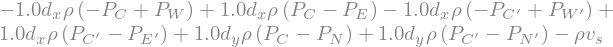

In [72]:
rho, Deltax, Deltay=sympy.symbols('rho, Delta_x, Delta_y ')
PC, PE, PEE, PW,PWW, PN,PNN, PS=sympy.symbols('P_C, P_E, P_{EE},P_W,P_{WW}, P_N,P_{NN}, P_S')
Pe, Pee, Pw, Pn=sympy.symbols(' P_e, P_{ee},P_w, P_n')
dx, dy= sympy.symbols('d_x, d_y')
UCstar,VCstar, UEstar,  UWstar, VNstar =sympy.symbols('U_C^*,V_C^*, U_E^*, U_W^*, V_N^*')
gC, gF= sympy.symbols('g_C, g_F')


Deltax=1; Deltay=1;
## condiciones de contorno
PS=PC #gradiente nulo de presión en la interfaz s
vs= sympy.Symbol('v_s') # velocidad en la cara sur (conocida)
    
# presiones interpoladas en las interfaces
pe=(PE+PC)/2;  pw=(PW+PC)/2; pn=(PN+PC)/2; ps=(PS+PC)/2; pee=(PEE+PE)/2 ; pww=(PWW+PW)/2 ; pnn=(PNN+PN)/2 ; 

#factores para interpolar geométricamente
gC= 1/2;  gF = 1/2;
#ecuaciones de cant de movimiento despejadas para cada componente
def cmov_x(pe, pw):
    return -dx*(pe-pw)

def cmov_y(ps, pn):
    return -dy*(pn -ps)
# sol de la ec de cant de movimiento para cada una de las velocidades en los centros de las celdas
UCstar= cmov_x(pe,pw); UEstar= cmov_x(pee,pe); UWstar= cmov_x(pw,pww)
VCstar= cmov_y(ps,pn); VNstar= cmov_y(pn,pnn)

print('UC*= \n', sympy.pretty(UCstar))
print('UE*= \n', sympy.pretty(UEstar))
print('VC*= \n', sympy.pretty(VCstar))

## velocidades interpoladas en las interfaces
uestar=(gC*UCstar+gF*UEstar)-dx*((PE-PC)-gC*(pe-pw) -gF*(pee-pe))
uestar=uestar.simplify()
print('ue*= \n', sympy.pretty(uestar))

uwstar=(gC*UWstar+gF*UCstar)-dx*((PC-PW)-gC*(pe-pw) -gF*(pw-pww))
uwstar=uwstar.simplify()
print('uw*= \n', sympy.pretty(uwstar))

vnstar=(gC*VCstar+gF*VNstar)-dy*((PN-PC)-gC*(pn-ps) -gF*(pnn-pn))

vnstar=vnstar.simplify()
print('Vn*= \n', sympy.pretty(vnstar))
vsstar= vs


""" ecuaciones de corrección de la presión """ 
P_pC, P_pE, P_pEE, P_pW,P_pWW, P_pN, P_pNN, P_pS,P_pSS =sympy.symbols(" P_C',P_E', P_{EE}'',P_W',P_{WW}', P_N', P_{NN}', P_S', P_{SS}' ")

UCp,VCp, UEp,  UWp, VNp =sympy.symbols("U_C',V_C', U_E', U_W', V_N'")

# valores de correcciones a las presiones  interpoladas en las interfaces
p_pe=(P_pE+P_pC)/2;  p_pw=(P_pW+P_pC)/2; p_pn=(P_pN+P_pC)/2; p_ps=(P_pS+P_pC)/2; 
p_pee=(P_pEE+P_pE)/2 ; p_pww=(P_pWW+P_pW)/2 ; p_pnn=(P_pNN+P_pN)/2 ; 


# correcciones de las velocidades 
UCp= cmov_x(p_pe,p_pw); UEp= cmov_x(p_pee,p_pe) ; UWp= cmov_x(p_pw,p_pww)
VCp= cmov_y(p_ps,p_pn); VNp= cmov_y(p_pn,p_pnn)


## velocidades interpoladas en las interfaces
uep=(gC*UCp+gF*UEp)-dx*((P_pE-P_pC)-gC*(p_pe-p_pw) -gF*(p_pee-p_pe))
uep=uep.simplify()
print("ue'= \n", sympy.pretty(uep))
      
uwp=(gC*UWp+gF*UCp)-dx*((P_pC-P_pW)-gC*(p_pe-p_pw) -gF*(p_pw-p_pww))
uwp=uwp.simplify()
print("uw'= \n", sympy.pretty(uwp))
      
vnp=(gC*VCp+gF*VNp)-dy*((P_pN-P_pC)-gC*(p_pn-p_ps) -gF*(p_pnn-p_pn))
vnp=vnp.simplify()
print("Vn'= \n", sympy.pretty(vnp))
vsp= 0

# cons del caudal másico
      
(rho*uestar* Deltay+rho*uep* Deltay)+ (rho*vnstar* Deltax+rho*vnp* Deltax)-(rho*uwstar* Deltay+rho*uwp* Deltay)-(rho*vsstar* Deltax+rho*vsp* Deltax)

In [73]:
rho=1; Deltax=1;  Deltay=1;
PE=50;  PW=100; PN= 20;  
PEE=50; PWW=150; PNN=250;

PC=70

dx=1.0; dy=0.25;




Deltax=1; Deltay=1;
## condiciones de contorno
PS=PC #gradiente nulo de presión en la interfaz s
vs=20 # velocidad en la cara sur (conocida)
    
# presiones interpoladas en las interfaces
pe=(PE+PC)/2;  pw=(PW+PC)/2; pn=(PN+PC)/2; ps=(PS+PC)/2; pee=(PEE+PE)/2 ; pww=(PWW+PW)/2 ; pnn=(PNN+PN)/2 ; 

#factores para interpolar geométricamente
gC= 1/2;  gF = 1/2;

#evaluacion de las predicciones de las velocidades con la ec de cmov
UCstar= cmov_x(pe,pw); UEstar= cmov_x(pee,pe); UWstar= cmov_x(pw,pww)
VCstar= cmov_y(ps,pn); VNstar= cmov_y(pn,pnn)

print('UC*= ', UCstar)
print('UE*= ', UEstar)
print('VC*= ', VCstar)

## velocidades interpoladas en las interfaces
uestar=(gC*UCstar+gF*UEstar)-dx*((PE-PC)-gC*(pe-pw) -gF*(pee-pe))

print('ue*= ', uestar)

uwstar=(gC*UWstar+gF*UCstar)-dx*((PC-PW)-gC*(pe-pw) -gF*(pw-pww))

print('uw*= ', uwstar)

vnstar=(gC*VCstar+gF*VNstar)-dy*((PN-PC)-gC*(pn-ps) -gF*(pnn-pn))

print('Vn*=', vnstar)
vsstar= vs


""" ecuaciones de corrección de la presión """ 
P_pC, P_pE, P_pEE, P_pW,P_pWW, P_pN, P_pNN, P_pS,P_pSS =sympy.symbols(" P_C',P_E', P_{EE}'',P_W',P_{WW}', P_N', P_{NN}', P_S', P_{SS}' ")

UCp,VCp, UEp,  UWp, VNp =sympy.symbols("U_C',V_C', U_E', U_W', V_N'")

# valores de correcciones a las presiones  interpoladas en las interfaces
p_pe=(P_pE+P_pC)/2;  p_pw=(P_pW+P_pC)/2; p_pn=(P_pN+P_pC)/2; p_ps=(P_pS+P_pC)/2; 
p_pee=(P_pEE+P_pE)/2 ; p_pww=(P_pWW+P_pW)/2 ; p_pnn=(P_pNN+P_pN)/2 ; 


# correcciones de las velocidades 
UCp= cmov_x(p_pe,p_pw); UEp= cmov_x(p_pee,p_pe); UWp= cmov_x(p_pw,p_pww)
VCp= cmov_y(p_ps,p_pn); VNp= cmov_y(p_pn,p_pnn)


## velocidades interpoladas en las interfaces
uep=(gC*UCp+gF*UEp)-dx*((P_pE-P_pC)-gC*(p_pe-p_pw) -gF*(p_pee-p_pe))
uep=uep.simplify()
print("ue'= \n", sympy.pretty(uep))
      
uwp=(gC*UWp+gF*UCp)-dx*((P_pC-P_pW)-gC*(p_pe-p_pw) -gF*(p_pw-p_pww))
uwp=uwp.simplify()
print("uw'= \n", sympy.pretty(uwp))
      
vnp=(gC*VCp+gF*VNp)-dy*((P_pN-P_pC)-gC*(p_pn-p_ps) -gF*(p_pnn-p_pn))
vnp=vnp.simplify()
print("Vn'= \n", sympy.pretty(vnp))
vsp= 0

# cons del caudal másico
      
(rho*uestar* Deltay+rho*uep* Deltay)+ (rho*vnstar* Deltax+rho*vnp* Deltax)-(rho*uwstar* Deltay+rho*uwp* Deltay)-(rho*vsstar* Deltax+rho*vsp* Deltax)

UC*=  25.0
UE*=  10.0
VC*=  6.25
ue*=  20.0
uw*=  30.0
Vn*= 12.5
ue'= 
 1.0⋅P_C' - 1.0⋅P_E'
uw'= 
 -1.0⋅P_C' + 1.0⋅P_W'
Vn'= 
 0.25⋅P_C' - 0.25⋅P_N'
